# Dataset / Imports:

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Libraries


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import warnings
import librosa
import librosa.display
import numpy as np
import glob
import os

print("Versions des librairies importantes :")
print(f"  Librosa:      {librosa.__version__}")
print(f"  NumPy:        {np.__version__}")

Versions des librairies importantes :
  Librosa:      0.11.0
  NumPy:        2.0.2


## Dataset

In [ ]:
dataset_path = "/content/drive/MyDrive/Artishow/Data/genres_original"

subfolders = os.listdir(dataset_path)
print("Sous-dossiers:", subfolders)

audio_files = glob.glob(f"{dataset_path}/**/*.wav", recursive=True)
print(f"Nombre de fichiers audio: {len(audio_files)}")

Sous-dossiers: ['jazz', 'country', 'pop', 'reggae', 'blues', 'hiphop', 'classical', 'disco', 'metal', 'rock']
Nombre de fichiers audio: 999


# PHASE 1 : Classificateurs de genres - Genre Classifiers


## Approche 1 : Machine Learning Classifiers

### Extraction des features


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib
import os
import zipfile
from IPython.display import FileLink

X = [] #features
Y = [] #labels

def extract_features(file_path, duration=30, sr=22050):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)

    # Fonction pour extraire la moyenne et l'écart-type
    def stats(feature):
        return list(map(float, np.mean(feature, axis=1))) + list(map(float, np.std(feature, axis=1)))

    # Extraction des features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    print(len(mfcc[0]))
    rms = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    flatness = librosa.feature.spectral_flatness(y=y)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zero_crossing = librosa.feature.zero_crossing_rate(y=y)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    # Construction du vecteur de features
    features = []
    for f in [mfcc, rms, spectral_centroid, bandwidth, contrast, flatness, rolloff, tonnetz, zero_crossing]:
        features.extend(stats(f))
    features.append(float(tempo))

    genre = (os.path.splitext(os.path.basename(file_path))[0]).split('.')[0]
    print("Genre connu : " + genre)
    print("")

    X.append(features)
    Y.append(genre)

i = 0
for file in audio_files:
    i+=1
    print(i)
    extract_features(file)

df = pd.DataFrame(X)
df['genre'] = Y
df['genre'] = df['genre'].astype('category')
genre_mapping = dict(enumerate(df['genre'].cat.categories))
df['genre'] = df['genre'].astype('category').cat.codes

X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=['genre'],), df['genre'], test_size=0.2, random_state = 42,stratify = Y)
print(Y_train.tolist())
print(Y_test.tolist())

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

save_dir = '/content/drive/MyDrive/Artishow/Modèle/ML'

# Sauvegarde des fichiers
joblib.dump(X_train, os.path.join(save_dir, "X_train.pkl"))
joblib.dump(X_test, os.path.join(save_dir, "X_test.pkl"))
joblib.dump(Y_train, os.path.join(save_dir, "Y_train.pkl"))
joblib.dump(Y_test, os.path.join(save_dir, "Y_test.pkl"))
joblib.dump(scaler, os.path.join(save_dir, "scaler.pkl"))
joblib.dump(genre_mapping, os.path.join(save_dir, "genre_mapping.pkl"))

files_to_zip = [
    "X_train.pkl",
    "X_test.pkl",
    "Y_train.pkl",
    "Y_test.pkl",
    "scaler.pkl",
    "genre_mapping.pkl"
]

zip_filename = "features_data.zip"
zip_path = os.path.join(save_dir, zip_filename)

with zipfile.ZipFile(zip_path, "w") as zipf:
    for filename in files_to_zip:
        file_path = os.path.join(save_dir, filename)
        zipf.write(file_path, arcname=filename)

# Lien pour télécharger
display(FileLink(zip_path))

1


KeyboardInterrupt: 

In [ ]:
# Stocker les features/labels

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib
import os
import zipfile
from IPython.display import FileLink

X = [] #features
Y = [] #labels

def extract_features(file_path, duration=30, sr=22050):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)

    # Fonction pour extraire la moyenne et l'écart-type
    def stats(feature):
        return list(map(float, np.mean(feature, axis=1))) + list(map(float, np.std(feature, axis=1)))

    # Extraction des features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    print(len(mfcc[0]))
    rms = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    flatness = librosa.feature.spectral_flatness(y=y)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zero_crossing = librosa.feature.zero_crossing_rate(y=y)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    # Construction du vecteur de features
    features = []
    for f in [mfcc, rms, spectral_centroid, bandwidth, contrast, flatness, rolloff, tonnetz, zero_crossing]:
        features.extend(stats(f))
    features.append(float(tempo))

    genre = (os.path.splitext(os.path.basename(file_path))[0]).split('.')[0]
    print("Genre connu : " + genre)

    """print(np.array(features, dtype=np.float32))"""  # Conversion finale
    print("")

    X.append(features)
    Y.append(genre)

### Fichiers Préentrainés

In [ ]:
# Fichiers Préentrainés (GTZAN)
import joblib
import os

X_train = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/X_train.pkl')
Y_train = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/Y_train.pkl')
X_test = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/X_test.pkl')
Y_test = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/Y_test.pkl')
genre_mapping = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}

print(Y_train)
print(genre_mapping)

40     5
107    2
969    9
21     5
64     5
      ..
127    2
966    9
700    3
714    3
131    2
Name: genre, Length: 799, dtype: int8
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [ ]:
# Fichiers Préentrainés (MTG-JAMENDO)
import joblib
import os

X_train_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/X_train.pkl')
Y_train_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/Y_train.pkl')
X_test_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/X_test.pkl')
Y_test_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/Y_test.pkl')
mood_mapping = {0: 'dark', 1: 'deep', 2: 'dream', 3: 'emotional', 4: 'epic', 5: 'happy', 6: 'motivational', 7: 'relaxing', 8: 'romantic', 9: 'sad'}

print(Y_train_mood)
print(mood_mapping)

667    7
361    7
789    7
566    7
139    4
      ..
413    3
481    2
500    5
181    0
404    4
Name: mood, Length: 748, dtype: int8
{0: 'dark', 1: 'deep', 2: 'dream', 3: 'emotional', 4: 'epic', 5: 'happy', 6: 'motivational', 7: 'relaxing', 8: 'romantic', 9: 'sad'}


### Classifiers

In [ ]:
#SVM

from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score


#Genre
model = SVC(kernel='linear')
model.fit(X_train, Y_train)
save_dir = '/content/drive/MyDrive/Artishow/Modèle/ML'
joblib.dump(model, os.path.join(save_dir, "svm_model.pkl"))

pred = model.predict(X_test)
print("Prédiction (Genre) : " + str(pred))

accuracy = accuracy_score(Y_test, pred)
print(f'Précision (Genre) : {accuracy:.2%}')


#Mood
model_mood = SVC(kernel='linear')
model_mood.fit(X_train_mood, Y_train_mood)
save_dir = '/content/drive/MyDrive/Artishow/Modèle/ML_moods'
joblib.dump(model_mood, os.path.join(save_dir, "svm_model_mood.pkl"))

pred_mood = model_mood.predict(X_test_mood)
print("Prédiction (Mood) : " + str(pred_mood))

accuracy = accuracy_score(Y_test_mood, pred_mood)
print(f'Précision (Mood) : {accuracy:.2%}')




In [ ]:
#LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#Mood
model = LogisticRegression()
model.fit(X_train, Y_train)

pred = model.predict(X_test)
save_dir = '/content/drive/MyDrive/Artishow/Modèle/ML'
joblib.dump(model, os.path.join(save_dir, "LogisticRegModel.pkl"))

print("Prédiction (Genre) : " + str(pred))
accuracy = accuracy_score(Y_test, pred)
print(f'Précision (Genre) : {accuracy:.2%}')


#Genre
model_mood = LogisticRegression()
model_mood.fit(X_train_mood, Y_train_mood)

pred_mood = model_mood.predict(X_test_mood)
save_dir = '/content/drive/MyDrive/Artishow/Modèle/ML_moods'
joblib.dump(model_mood, os.path.join(save_dir, "LogisticRegModel_mood.pkl"))

print("Prédiction (Genre) : " + str(pred_mood))
accuracy = accuracy_score(Y_test_mood, pred_mood)
print(f'Précision (Genre) : {accuracy:.2%}')

In [ ]:
#RandomForest

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier


#Genre
rf_model = RandomForestClassifier(n_estimators=103, random_state=42)

rf_model.fit(X_train, Y_train)
Y_pred = rf_model.predict(X_test)
save_dir = '/content/drive/MyDrive/Artishow/Modèle/ML'
joblib.dump(rf_model, os.path.join(save_dir, "rf_model.pkl"))

accuracy = accuracy_score(Y_test, Y_pred)
print("Prédiction (Genre)", Y_pred)
print(f"Précision (Genre) : {accuracy:.2%}")

#Mood
rf_model_mood = RandomForestClassifier(n_estimators=103, random_state=42)

rf_model_mood.fit(X_train_mood, Y_train_mood)
Y_pred_mood = rf_model_mood.predict(X_test_mood)
save_dir = '/content/drive/MyDrive/Artishow/Modèle/ML_moods'
joblib.dump(rf_model, os.path.join(save_dir, "rf_model_mood.pkl"))

accuracy = accuracy_score(Y_test_mood, Y_pred_mood)
print("Prédiction (Mood)", Y_pred_mood)
print(f"Précision (Mood) : {accuracy:.2%}")


In [ ]:
#GradientBoosting

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

#Genre
model_gbt = GradientBoostingClassifier()
model_gbt.fit(X_train, Y_train)
save_dir = '/content/drive/MyDrive/Artishow/Modèle/ML'
joblib.dump(model_gbt, os.path.join(save_dir, "gbt_model.pkl"))
Y_pred_gbt = model_gbt.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred_gbt)
print("Prédiction (Genre)", Y_pred)
print(f"Précision (Genre)): {accuracy:.2%}")

#Mood
model_gbt_mood = GradientBoostingClassifier()
model_gbt_mood.fit(X_train_mood, Y_train_mood)
save_dir = '/content/drive/MyDrive/Artishow/Modèle/ML_moods'
joblib.dump(model_gbt_mood, os.path.join(save_dir, "gbt_model_mood.pkl"))
Y_pred_gbt_mood = model_gbt_mood.predict(X_test_mood)
accuracy = accuracy_score(Y_test_mood, Y_pred_gbt_mood)
print("Prédiction (Mood)", Y_pred_gbt_mood)
print(f"Précision (Mood): {accuracy:.2%}")

In [ ]:
#K-Nearest Neighbors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#Genre
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)

pred_k = knn.predict(X_test)
save_dir = '/content/drive/MyDrive/Artishow/Modèle/ML'
joblib.dump(knn, os.path.join(save_dir, "knn_model.pkl"))

print("Prédiction (Genre) :" + str(pred_k))
accuracy = accuracy_score(Y_test, pred_k)
print(f'Précision (Genre): {accuracy:.2%}')


#Mood
knn_mood = KNeighborsClassifier(n_neighbors=5)
knn_mood.fit(X_train_mood, Y_train_mood)

pred_k_mood = knn_mood.predict(X_test_mood)
save_dir = '/content/drive/MyDrive/Artishow/Modèle/ML_moods'
joblib.dump(knn, os.path.join(save_dir, "knn_model_mood.pkl"))

print("Prédiction (Mood) :" + str(pred_k_mood))
accuracy = accuracy_score(Y_test_mood, pred_k_mood)
print(f'Précision (Mood): {accuracy:.2%}')

In [ ]:
#Version 2 pas fini : Pour tester sur une musique de son choix - To try on a chosen music

import joblib

X_genre = []
X_mood = []

def pred_musique2(file_path, model_genre):

  extract_features(file_path, duration=30, sr=22050)
  df_test = pd.DataFrame(X)
  scaler = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/scaler.pkl')
  df_test_scaled = scaler.transform(df_test)
  prediction = model.predict(df_test_scaled)
  print(f"Prédiction (Genre): {genre_mapping[int(prediction[0])]}")
  X.clear()




def pred_musique(file_path, model):
  extract_features(file_path, duration=30, sr=22050)
  df_test = pd.DataFrame(X)
  scaler = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/scaler.pkl')
  df_test_scaled = scaler.transform(df_test)
  prediction = model.predict(df_test_scaled)
  print(f"Prédiction (Genre): {genre_mapping[int(prediction[0])]}")
  X.clear()
  return genre_mapping[int(prediction[0])]


svm_model = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/svm_model.pkl')
knn_model = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/knn_model.pkl')
gbt_model = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/gbt_model.pkl')
rf_model = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/rf_model.pkl')
LogisticRegModel = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/LogisticRegModel.pkl')

svm_model_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/svm_model_mood.pkl')
knn_model_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/knn_model_mood.pkl')
gbt_model_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/gbt_model_mood.pkl')
rf_model_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/rf_model_mood.pkl')
LogisticRegModel_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/LogisticRegModel_mood.pkl')

def pred_globale(file_path):
  print("==== SVM ====")
  pred_musique2(file_path, svm_model)
  print("==== KNN ====")
  pred_musique2(file_path, knn_model)
  print("==== Gradient Boosting ====")
  pred_musique2(file_path, gbt_model)
  print("==== Random Forest ====")
  pred_musique2(file_path, rf_model)
  print("==== Logistic Regression ====")
  pred_musique2(file_path, LogisticRegModel)

pred_globale('/content/drive/MyDrive/Artishow/Musique perso/Dua Lipa - Houdini.mp3')

In [ ]:
#V1 pour tester sur une musique de son choix (GENRE)

X_genre = []
X_mood = []

def pred_musique_2(file_path, model_genre, model_mood):

  extract_features(file_path, duration=30, sr=22050)

  #Genre
  df_test = pd.DataFrame(X_genre)
  scaler = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/scaler.pkl')
  df_test_scaled = scaler.transform(df_test)
  prediction = model_genre.predict(df_test_scaled)
  print(f"Prédiction (Genre): {genre_mapping[int(prediction[0])]}")
  X_genre.clear()

  #Mood
  df_test_mood = pd.DataFrame(X_mood)
  scaler_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/scaler.pkl')
  df_test_scaled_mood = scaler_mood.transform(df_test_mood)
  prediction = model_mood.predict(df_test_scaled_mood)
  print(prediction)
  print(f"Prédiction (Mood): {mood_mapping[int(prediction[0])]}")
  X_mood.clear()


def pred_musique(file_path, model):
  extract_features(file_path, duration=30, sr=22050)
  df_test = pd.DataFrame(X)
  scaler = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/scaler.pkl')
  df_test_scaled = scaler.transform(df_test)
  prediction = model.predict(df_test_scaled)
  print(f"Prédiction (Genre): {genre_mapping[int(prediction[0])]}")
  X.clear()
  return genre_mapping[int(prediction[0])]

def pred_musique_mood(file_path, model):
  extract_features(file_path, duration=30, sr=22050)
  df_test = pd.DataFrame(X)
  scaler = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/scaler.pkl')
  df_test_scaled = scaler.transform(df_test)
  prediction = model.predict(df_test_scaled)
  print(prediction)
  print(f"Prédiction (Mood) : {mood_mapping[int(prediction[0])]}")
  X.clear()
  return mood_mapping[int(prediction[0])]

svm_model = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/svm_model.pkl')
knn_model = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/knn_model.pkl')
gbt_model = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/gbt_model.pkl')
rf_model = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/rf_model.pkl')
LogisticRegModel = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/LogisticRegModel.pkl')

svm_model_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/svm_model_mood.pkl')
knn_model_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/knn_model_mood.pkl')
gbt_model_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/gbt_model_mood.pkl')
rf_model_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/rf_model_mood.pkl')
LogisticRegModel_mood = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/LogisticRegModel_mood.pkl')

def pred_globale(file_path):
  print("==== SVM ====")
  pred_musique(file_path, svm_model)
  pred_musique_mood(file_path, svm_model_mood)
  print("==== KNN ====")
  pred_musique(file_path, knn_model)
  pred_musique_mood(file_path, knn_model_mood)
  print("==== Gradient Boosting ====")
  pred_musique(file_path, gbt_model)
  pred_musique_mood(file_path, gbt_model_mood)
  print("==== Random Forest ====")
  pred_musique(file_path, rf_model)
  pred_musique_mood(file_path, rf_model_mood)
  print("==== Logistic Regression ====")
  pred_musique(file_path, LogisticRegModel)
  pred_musique_mood(file_path, LogisticRegModel_mood)

pred_globale('/content/drive/MyDrive/Artishow/Musique perso/Dua Lipa - Houdini.mp3')

## Approche 2 : CNN + Spectrograms


### Conversion en spectrogramme

In [ ]:
#Spectrogramme

import shutil
import os
import random


def audio_to_mel_spec(audio, save_path, sr=22050, n_mels=128, hop_length=512):
    y, sr = librosa.load(audio, sr=sr, duration=30)
    melspec = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=n_mels
                                             , hop_length=hop_length)
    melspec_db = librosa.power_to_db(melspec, ref=np.max)

    # Plot & save spectrogram
    plt.figure(figsize=(4.32, 2.88), dpi=100)  # image 224x224 pixels
    #librosa.display.specshow(melspec_db)  # ou 'inferno'
    plt.imshow(melspec_db, aspect='auto', origin='lower', cmap='magma', vmin=-42, vmax=0)

    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

output_dir = "/content/drive/MyDrive/Artishow/spectrogramStorage"
i=0

for audio in audio_files[:1000]:
    i+=1
    print(i)
    file_name = os.path.basename(audio).replace('.mp3','.png').replace('.wav','.png')
    save_path = os.path.join(output_dir, file_name)
    print(file_name)
    audio_to_mel_spec(audio, save_path)

shutil.make_archive("/kaggle/working/dataset_spectrograms", 'zip', output_dir)
print("fichier créé pret a download")

In [ ]:
#Mettre en forme les données

import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

spectrograms_dir = '/content/drive/MyDrive/Artishow/Data/images_original'
data = []

for genre in os.listdir(spectrograms_dir):
    genre_dir = os.path.join(spectrograms_dir, genre)
    if not os.path.isdir(genre_dir):
        continue
    for file in os.listdir(genre_dir):
        if file.endswith(".png"):
            file_path = os.path.join(genre_dir, file)
            data.append([file_path, genre])

df = pd.DataFrame(data, columns=["filename", "genre"])
display(df.head())

IMG_SIZE = (224,224)
BATCH_SIZE = 32
DATASET_DIR = "dataset_spectrograms"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe = df,
    x_col="filename",
    y_col="genre",
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    subset = "training"
)

val_generator = datagen.flow_from_dataframe(
    dataframe = df,
    x_col="filename",
    y_col="genre",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode = "categorical",
    subset = "validation"
)


,filename,genre
0,/content/drive/MyDrive/Artishow/Data/images_or...,metal
1,/content/drive/MyDrive/Artishow/Data/images_or...,metal
2,/content/drive/MyDrive/Artishow/Data/images_or...,metal
3,/content/drive/MyDrive/Artishow/Data/images_or...,metal
4,/content/drive/MyDrive/Artishow/Data/images_or...,metal


Found 800 validated image filenames belonging to 10 classes.
Found 199 validated image filenames belonging to 10 classes.


### Convolutional Neural Network

In [ ]:
#VGG-16

import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

filepath = "/content/drive/MyDrive/Artishow/Modèle/IA/vgg16_weights_tf_dim_ordering_tf_kernels_notop (1).h5"
base_model = VGG16(weights=filepath,
                include_top=False,
                input_shape=((224,224, 3))
)

base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(df['genre'].nunique(),activation='softmax')])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

model.save("/content/drive/MyDrive/Artishow/Modèle/IA/vgg16_genre_classification.h5")

loss, accuracy = model.evaluate(val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score

model = tf.keras.models.load_model("/content/drive/MyDrive/Artishow/Modèle/IA/vgg16_genre_classification.h5")
pred = model.predict(val_generator)

true_classes = val_generator.classes
pred_classes = np.argmax(pred, axis=1)
acc = accuracy_score(true_classes, pred_classes)
print(f"Accuracy sur validation set : {acc:.2%}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 107s 15s/step
Accuracy sur validation set : 0.00%


In [ ]:
audio_to_mel_spec("/content/drive/MyDrive/Artishow/Musique perso/Dua Lipa - Houdini.mp3", "/content/drive/MyDrive/Artishow/spectrogramStorage/MusiquePerso/specPerso")
import keras.preprocessing.image as image
# Charger l’image et la préparer pour le modèle

def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.  # Si tu as utilisé rescale=1./255
    return img_array

# Charger ton modèle entraîné
model = tf.keras.models.load_model("/content/drive/MyDrive/Artishow/Modèle/IA/vgg16_genre_classification.h5")

# Exemple d'audio à prédire
spec_path = "/content/drive/MyDrive/Artishow/spectrogramStorage/MusiquePerso/specPerso.png"
img_array = load_image(spec_path)

# Prédiction
prediction = model.predict(img_array)
print(prediction)
predicted_indices = np.argsort(prediction)[0][-2:][::-1]
print(f"Genres prédits : {predicted_indices}")

NameError: name 'audio_to_mel_spec' is not defined

## Benchmark

In [ ]:
#Benchmark

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(kernel='linear', probability=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=103, random_state=42)
}

results = []

def compute_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

def compute_auc(y_true, y_prob):
    if y_prob is not None:
        try:
            y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
            return roc_auc_score(y_true_bin, y_prob, average='weighted', multi_class='ovr')
        except ValueError:
            return None
    return None

print("Réponse :", Y_test.tolist())

#Entrainement

for name, model in models.items():
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    accuracy = accuracy_score(Y_test, pred)
    f1 = compute_f1_score(Y_test, pred)
    auc = compute_auc(Y_test, prob)
    print(f"Prédiction {name} : {pred}")
    results.append((name, accuracy, f1, auc))

#Affichage
results_df = pd.DataFrame(results, columns=["Modele", "Precision", "F1-Score", "AUC"])
print(results_df.sort_values(by="F1-Score", ascending=False))


Réponse : [1, 0, 6, 5, 0, 2, 9, 2, 4, 5, 0, 0, 8, 0, 9, 3, 8, 5, 3, 9, 2, 6, 0, 2, 0, 1, 7, 8, 5, 5, 6, 2, 5, 4, 1, 6, 9, 4, 2, 3, 8, 9, 7, 0, 5, 5, 6, 1, 4, 7, 4, 6, 4, 5, 8, 3, 3, 1, 1, 8, 6, 8, 8, 9, 3, 9, 9, 1, 9, 7, 6, 8, 1, 7, 8, 4, 3, 7, 7, 7, 3, 7, 8, 4, 5, 9, 8, 4, 9, 5, 6, 8, 6, 3, 2, 5, 5, 2, 8, 8, 6, 0, 8, 7, 6, 9, 3, 3, 6, 3, 0, 0, 1, 2, 1, 2, 1, 9, 8, 7, 3, 0, 5, 9, 8, 1, 6, 4, 6, 3, 6, 4, 7, 5, 7, 2, 3, 2, 3, 8, 5, 0, 3, 0, 2, 4, 4, 0, 1, 4, 7, 1, 1, 0, 9, 0, 6, 5, 1, 0, 3, 3, 4, 5, 8, 9, 9, 2, 7, 0, 6, 5, 0, 9, 7, 1, 7, 4, 2, 3, 6, 4, 9, 4, 1, 7, 6, 2, 5, 2, 4, 1, 7, 7, 4, 2, 2, 1, 9, 2]
Prédiction Logistic Regression : [1 9 6 5 0 9 9 2 3 5 0 4 8 0 9 3 8 5 3 9 2 6 0 2 0 1 7 8 5 5 6 2 5 4 1 6 9
 0 9 3 2 9 7 0 5 5 6 1 4 2 4 6 6 5 8 3 3 1 5 8 6 8 8 9 2 6 3 1 9 7 6 8 1 7
 3 6 3 7 7 3 3 7 2 4 0 9 8 4 9 5 6 8 6 3 9 5 5 2 8 8 6 0 8 7 6 3 9 3 6 6 2
 0 1 2 1 2 1 3 8 7 6 0 5 9 7 1 6 4 6 3 6 4 7 8 7 2 3 2 3 9 5 0 3 0 2 8 4 0
 1 2 7 1 1 0 8 0 6 5 1 0 2 4 2 1 8 3 9 2 7 0 6 5 0 7 7 1

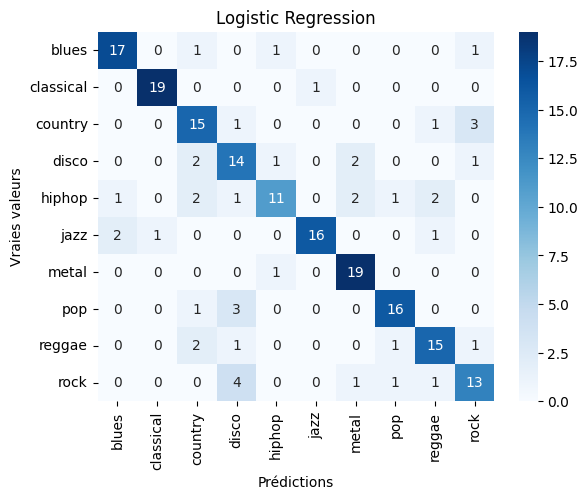

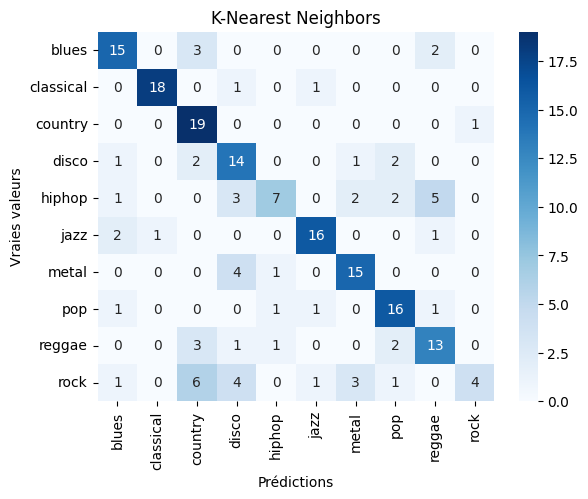

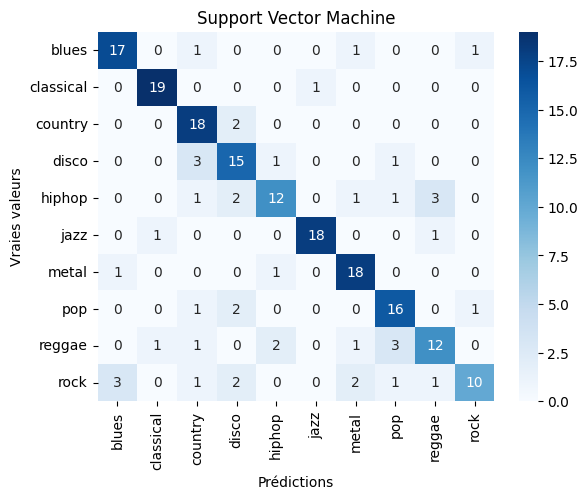

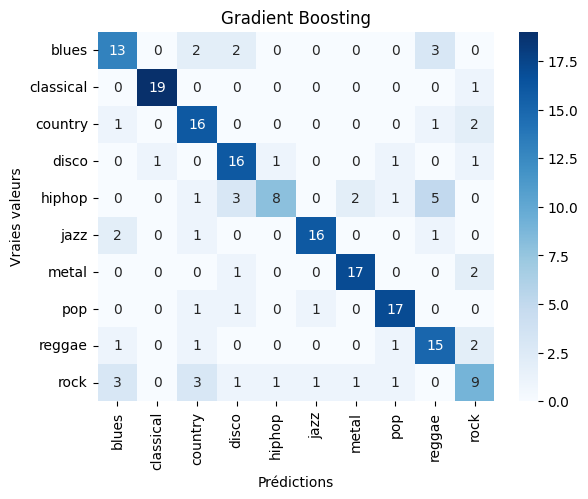

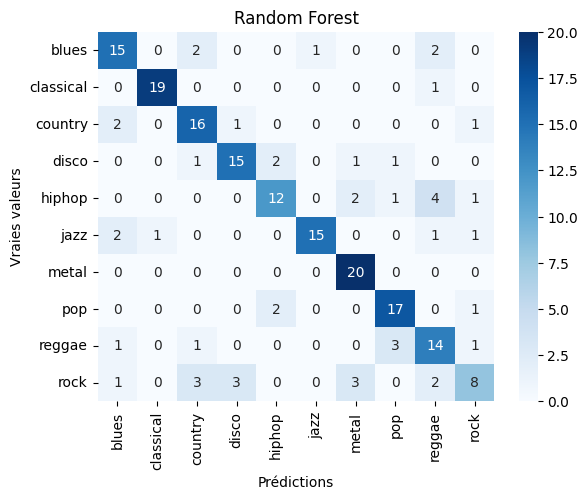

In [ ]:
#Matrice de confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


use_mood = False  # Mets False pour genre

mood_mapping = {0: 'dark', 1: 'deep', 2: 'dream', 3: 'emotional', 4: 'epic', 5: 'happy', 6: 'motivational', 7: 'relaxing', 8: 'romantic', 9: 'sad'}
genre_mapping = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}

mapping = mood_mapping if use_mood else genre_mapping
labels = [mapping[cle] for cle in mapping]

models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(kernel='linear', probability=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=103, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    cm = confusion_matrix(Y_test, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", # fmt="d" pour afficher des entiers
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies valeurs')
    plt.title(name)
    plt.show()


## Ensemble learning

In [ ]:
model_mapping = {0:"SVM", 1:"Logistic Regression", 2:"Random Forest", 3:"Gradient Boosting", 4:"k-Nearest Neighbors", 5:"Ensemble Learnings"}

In [ ]:
# ENSEMBLE LEARNING
def pos_max(t):
    p = 0
    for i in range(len(t)):
        if t[i]>t[p]:
            p = i
    return p

# Fonction qui prend les N_t (5) tableaux en entrées et renvoie un tableau
# ensemble learning : e.l.
def ensemble_learning(Preds):
  Y_pred_el = []
  N_t = len(Preds)
  N = len(Preds[0])
  for i in range(N):
      total_par_genre = [0 for k in range(len(genre_mapping))]
      for j in range(N_t):
          total_par_genre[Preds[j][i]] += 1
      # print(total_par_genre)
      g = pos_max(total_par_genre)
      Y_pred_el.append(g)
  return Y_pred_el

In [ ]:
#All Classifiers
# couleur : \033[1;3Om #30 à 37 avant le m

# IMPORTS
from time import sleep
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

# FONCTION GENERALE --- UTILISABLE POUR PRÉDIRE LE GENRE DE N'IMPORTE QUELLE MUSIQUE
def model_predictions(X_input):
  scaler = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/scaler.pkl')
  X_input = scaler.transform(X_input)
  Preds = []
  Y_pred_svm = model_svm.predict(X_input)
  Preds.append(Y_pred_svm)
  Y_pred_lr = model_lr.predict(X_input)
  Preds.append(Y_pred_lr)
  Y_pred_rf = model_rf.predict(X_input)
  Preds.append(Y_pred_rf)
  Y_pred_gbt = model_gbt.predict(X_input)
  Preds.append(Y_pred_gbt)
  Y_pred_knn = model_knn.predict(X_input)
  Preds.append(Y_pred_knn)
  Y_pred_el = ensemble_learning(Preds) #diff car e.l.
  Preds.append(Y_pred_el)
  return Preds

# TRAINING
model_svm = SVC(kernel='linear')
model_svm.fit(X_train, Y_train)
model_lr = LogisticRegression()
model_lr.fit(X_train, Y_train)
model_rf = RandomForestClassifier(n_estimators=103, random_state=42)
model_rf.fit(X_train, Y_train)
model_gbt = GradientBoostingClassifier()
model_gbt.fit(X_train, Y_train)
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, Y_train)

# POUR LE SET TEST
resultats = False
affichage = False
comparaison = True
if resultats:
  Preds = model_predictions(X_test)
  N_t = len(Preds)
  N = len(Preds[0])
  # ACCURACY
  accuracy_svm = accuracy_score(Y_test, Preds[0])
  print(f'\033[1;31m Précision SVM : {accuracy_svm:.2%}')
  accuracy_lr = accuracy_score(Y_test, Preds[1])
  print(f'\033[1;32m Précision LogisticRegression : {accuracy_lr:.2%}')
  accuracy_rf = accuracy_score(Y_test, Preds[2])
  print(f"\033[1;33m Précision RandomForest: {accuracy_rf:.2%}")
  accuracy_gbt = accuracy_score(Y_test, Preds[3])
  print(f"\033[1;34m Précision GradientBoosting: {accuracy_gbt:.2%}")
  accuracy_knn = accuracy_score(Y_test, Preds[4])
  print(f'\033[1;35m Précision k-NearestNeighbours : {accuracy_knn:.2%}')
  accuracy_el = accuracy_score(Y_test, Preds[N_t-1])
  print(f'\033[1;36m Précision EnsembleLearning : {accuracy_el:.2%}')

  # PREDICTIONS
  if affichage:
    if not comparaison:
      print("\033[1;31m prédictions SVM : " + str(Preds[0]))
      print("\033[1;32m prédictions LogisticRegression : " + str(Preds[1]))
      print("\033[1;33m prédictions RandomForest : " + str(Preds[2]))
      print("\033[1;34m prédictions GradientBoosting : " + str(Preds[3]))
      print("\033[1;35m prédictions K-Nearest Neighbors : " + str(Preds[4]))
      print("\033[1;36m prédictions EnsembleLearning : " + str(Preds[N_t-1]))
    else:
      print("\033[1;30m Toutes les prédictions : ")
      for i in range(N):
        for j in range(N_t):
          string = ''
          string += f'\033[1;{31+j}m'
          string += f'{Preds[j][i]} '
          print(string, end='')
        print(f'\033[1;30m \n')

In [ ]:
# -- on a besoin de extract features sans ajouter à X et Y

def array_features(files, duration=30, sr=22050):
  N_f = len(files)
  X_features = []
  Y_genres = []
  def stats(feature):
      return list(map(float, np.mean(feature, axis=1))) + list(map(float, np.std(feature, axis=1)))
  print('Extracting features :', end='')
  for i in range(N_f):
    file_path = files[i]
    file_name = os.path.basename(file_path).replace('.mp3','.png').replace('.wav','.png')
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    # Extraction des features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    rms = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    flatness = librosa.feature.spectral_flatness(y=y)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zero_crossing = librosa.feature.zero_crossing_rate(y=y)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    # Construction du vecteur de features
    features = []
    for f in [mfcc, rms, spectral_centroid, bandwidth, contrast, flatness, rolloff, tonnetz, zero_crossing]:
        features.extend(stats(f))
    features.append(float(tempo))
    X_features.append(features)
    genre = (os.path.splitext(os.path.basename(file_path))[0]).split('.')[0]
    Y_genres.append(genre)
    print(f'{i+1}✓', end='')
  print('')
  return X_features, Y_genres

In [ ]:
# SAMUEL -- on a besoin de extract features sans ajouter à X et Y

def array_features(files, duration=30, sr=22050):
  N_f = len(files)
  X_features = []
  Y_genres = []
  def stats(feature):
      return list(map(float, np.mean(feature, axis=1))) + list(map(float, np.std(feature, axis=1)))
  print('Extracting features :', end='')
  for i in range(N_f):
    file_path = files[i]
    file_name = os.path.basename(file_path).replace('.mp3','.png').replace('.wav','.png')
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    # Extraction des features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    rms = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    flatness = librosa.feature.spectral_flatness(y=y)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zero_crossing = librosa.feature.zero_crossing_rate(y=y)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    # Construction du vecteur de features
    features = []
    for f in [mfcc, rms, spectral_centroid, bandwidth, contrast, flatness, rolloff, tonnetz, zero_crossing]:
        features.extend(stats(f))
    features.append(float(tempo))
    X_features.append(features)
    genre = (os.path.splitext(os.path.basename(file_path))[0]).split('.')[0]
    Y_genres.append(genre)
    print(f'{i+1}✓', end='')
  print('')
  return X_features, Y_genres

# Juste le genre svp

def extract_known_genre(files, duration=30, sr=22050):
  N_f = len(files)
  Y_genres = []
  for i in range(N_f):
    file_path = files[i]
    genre = (os.path.splitext(os.path.basename(file_path))[0]).split('.')[0]
    Y_genres.append(genre)
  return Y_genres

In [ ]:
# FINAL EL FOR PREDICTION
# pour le moment tqt
# -----------------------------------------------------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

F = audio_files #np.random.choice(audio_files, 100, replace=False) # ou autre Files array
W = extract_known_genre(F)

df2 = pd.DataFrame(F)
df2['genre'] = W
df2['genre'] = df2['genre'].astype('category')
genre_mapping = dict(enumerate(df2['genre'].cat.categories))
df2['genre'] = df2['genre'].astype('category').cat.codes
F_train, F_test, W_train, W_test = train_test_split(df2.drop(columns=['genre'],), df2['genre'], test_size=0.2, random_state = 42,stratify = W)
F_train = F_train.squeeze().tolist()
F_test = F_test.squeeze().tolist()
W_train = W_train.tolist()
W_test = W_test.tolist()
F_meta_train, F_meta_test, W_meta_train, W_meta_test = train_test_split(F_test, W_test, test_size=0.2, random_state=42, stratify=W_test)
#save_dir = '/content/drive/MyDrive/Artishow/Modèle/ML' ça s'était pour logistic regression
#joblib.dump(model, os.path.join(save_dir, "Logi.pkl")) ça s'était pour logistic regression

In [ ]:
# essais ensemble learning 2
# partie cnn
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import keras.preprocessing.image as image
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import joblib

model_cnn = tf.keras.models.load_model("/content/drive/MyDrive/Artishow/Modèle/IA/vgg16_genre_classification.h5")
save_dir = "/content/drive/MyDrive/Artishow/spectrogramStorage/MusiquePerso"

def audio_to_mel_spec(audio_path, save_dir, sr=22050, n_mels=128, hop_length=512):
    y, sr = librosa.load(audio_path, sr=sr, duration=30)
    melspec = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=n_mels, hop_length=hop_length)
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    # Plot & save spectrogram
    plt.figure(figsize=(4.32, 2.88), dpi=100)  # image 224x224 pixels
    #librosa.display.specshow(melspec_db)  # ou 'inferno'
    plt.imshow(melspec_db, aspect='auto', origin='lower', cmap='magma', vmin=-42, vmax=0)
    plt.axis('off')
    plt.tight_layout(pad=0)
    # Generate unique filename
    file_name = os.path.basename(audio_path).replace('.mp3','.png').replace('.wav','.png')
    save_path = os.path.join(save_dir, file_name)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close() # Close the plot to prevent it from displaying
    return save_path

def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.  # Si tu as utilisé rescale=1./255
    return img_array

def pre_process_cnn(files):
  im_arrays = []
  spec_paths = []
  for f in files:
    spec_path = audio_to_mel_spec(f, save_dir)
    img_array = load_image(spec_path)
    im_arrays.append(img_array)
    spec_paths.append(spec_path) # Store the path to clean up later
  return np.vstack(im_arrays), spec_paths # Stack the images to a single numpy array

# partie machine learning
from time import sleep
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
# TRAINING
# à voir si besoin de réentraîner
model_svm = SVC(kernel='linear', probability=True)
model_svm.fit(X_train, Y_train)
model_lr = LogisticRegression()
model_lr.fit(X_train, Y_train)
model_rf = RandomForestClassifier(n_estimators=103, random_state=42)
model_rf.fit(X_train, Y_train)
model_gbt = GradientBoostingClassifier()
model_gbt.fit(X_train, Y_train)
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, Y_train)

# general
def model_probas(files): #CNN !!!!!!!
  scaler = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/scaler.pkl')
  X_features, _ = array_features(files) # le 2e c'est les genres
  X_input = scaler.transform(X_features)
  Y_probas_svm = model_svm.predict_proba(X_input)
  Y_probas_lr = model_lr.predict_proba(X_input)
  Y_probas_rf = model_rf.predict_proba(X_input)
  Y_probas_gbt = model_gbt.predict_proba(X_input)
  Y_probas_knn = model_knn.predict_proba(X_input)
  im_arrays, spec_paths = pre_process_cnn(files)
  Y_probas_cnn = model_cnn.predict(im_arrays)
  Z_input = []
  for i in range(len(files)): # Iterate through the number of files
    Z_input.append([*Y_probas_svm[i], *Y_probas_lr[i], *Y_probas_rf[i], *Y_probas_gbt[i], *Y_probas_knn[i], *Y_probas_cnn[i]])
  # Clean up generated spectrogram files #ça c'est l'ia google mais bon jvais laisser mdr
  for spec_path in spec_paths:
      os.remove(spec_path)
  return Z_input

#essai
#files1 = audio_files[:3]
#files2 = ["/content/drive/MyDrive/Artishow/Musique perso/Dua Lipa - Houdini.mp3"]
#Z = model_probas(files1)

In [ ]:
# ENSEMBLE LEARNING
def pos2_max(t):
  p1 = 0
  p2 = 0
  for i in range(len(t)):
    if t[i]>t[p1]:
      p2 = p1
      p1 = i
    elif t[i]>t[p2]:
      p2 = i
  return (p1, p2)

In [ ]:
# META MODEL TRAINING
Z_meta_train = model_probas(F_meta_train)
Z_meta_test = model_probas(F_meta_test)

scaler = StandardScaler()
Z_meta_train = scaler.fit_transform(Z_meta_train)
Z_meta_test = scaler.transform(Z_meta_test)

meta_model = LogisticRegression()
meta_model.fit(Z_meta_train, W_meta_train)
#W_meta_pred_test = meta_model.predict(Z_meta_test)
#accuracy = accuracy_score(W_meta_pred_test, W_meta_test)
#print(f'Précision du modèle : {accuracy:.2%}')
#W_2rep = meta_model_predictions(Z_meta_test)

Extracting features :

/tmp/ipython-input-84-4273300271.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓3✓4✓5✓6✓7✓8✓9✓10✓11✓12✓13✓14✓15✓16✓17✓18✓19✓20✓21✓22✓23✓24✓25✓26✓27✓28✓29✓30✓31✓32✓33✓34✓35✓36✓37✓38✓39✓40✓41✓42✓43✓44✓45✓46✓47✓48✓49✓50✓51✓52✓53✓54✓55✓56✓57✓58✓59✓60✓61✓62✓63✓64✓65✓66✓67✓68✓69✓70✓71✓72✓73✓74✓75✓76✓77✓78✓79✓80✓81✓82✓83✓84✓85✓86✓87✓88✓89✓90✓91✓92✓93✓94✓95✓96✓97✓98✓99✓100✓101✓102✓103✓104✓105✓106✓107✓108✓109✓110✓111✓112✓113✓114✓115✓116✓117✓118✓119✓120✓121✓122✓123✓124✓125✓126✓127✓128✓129✓130✓131✓132✓133✓134✓135✓136✓137✓138✓139✓140✓141✓142✓143✓144✓145✓146✓147✓148✓149✓150✓151✓152✓153✓154✓155✓156✓157✓158✓159✓160✓
5/5 ━━━━━━━━━━━━━━━━━━━━ 88s 17s/step
Extracting features :

/tmp/ipython-input-84-4273300271.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓3✓4✓5✓6✓7✓8✓9✓10✓11✓12✓13✓14✓15✓16✓17✓18✓19✓20✓21✓22✓23✓24✓25✓26✓27✓28✓29✓30✓31✓32✓33✓34✓35✓36✓37✓38✓39✓40✓
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step


In [ ]:
def meta_model_predictions(Z_input):
  Ws = meta_model.predict_proba(Z_input)
  W_2rep = [pos2_max(v) for v in Ws]
  return W_2rep

In [ ]:
print(F_meta_train)

['/content/drive/MyDrive/Artishow/Data/genres_original/reggae/reggae.00046.wav', '/content/drive/MyDrive/Artishow/Data/genres_original/metal/metal.00075.wav', '/content/drive/MyDrive/Artishow/Data/genres_original/jazz/jazz.00074.wav', '/content/drive/MyDrive/Artishow/Data/genres_original/blues/blues.00054.wav', '/content/drive/MyDrive/Artishow/Data/genres_original/jazz/jazz.00009.wav', '/content/drive/MyDrive/Artishow/Data/genres_original/metal/metal.00086.wav', '/content/drive/MyDrive/Artishow/Data/genres_original/metal/metal.00073.wav', '/content/drive/MyDrive/Artishow/Data/genres_original/disco/disco.00032.wav', '/content/drive/MyDrive/Artishow/Data/genres_original/blues/blues.00024.wav', '/content/drive/MyDrive/Artishow/Data/genres_original/metal/metal.00044.wav', '/content/drive/MyDrive/Artishow/Data/genres_original/country/country.00024.wav', '/content/drive/MyDrive/Artishow/Data/genres_original/rock/rock.00008.wav', '/content/drive/MyDrive/Artishow/Data/genres_original/pop/pop.0

In [ ]:
print(audio_files[2:4])

['/content/drive/MyDrive/Artishow/Data/genres_original/jazz/jazz.00003.wav', '/content/drive/MyDrive/Artishow/Data/genres_original/jazz/jazz.00004.wav']


# PHASE 2 : Playlist


## Triage d'un tableau par genre - sorting a table by genre


In [ ]:
# Algorithme qui prend plein de musiques et en détermine le genre
from tabulate import tabulate
import random

# Récupérer des files -- à changer avec un dossier
subset = random.sample(audio_files, 10)
X_subset, Y_genres = array_features(subset)
X_names = [os.path.basename(file).replace('.mp3','').replace('.wav','') for file in subset] #file_name for file in subset

Songs = list(map(lambda x,y : (x,y), X_names, Y_genres))
affiche_tab_t_g(Songs, statut="connu")

tab = model_predictions(X_subset)
for i in range(len(tab)):
  print(model_mapping[i])
  Songs = list(map(lambda x, y: (x,genre_mapping[y]), X_names, tab[i]))
  affiche_tab_t_g(Songs)

In [ ]:
# Algorithme qui affiche un tableau (titre, genre) trié par genre
from tabulate import tabulate
import random

# L'algo
def affiche_tab_t_g(couples, statut="prédit"):
  couples.sort(key=lambda tuple: tuple[1]) #sort by second parameter (ordre alphabétique)
  print(tabulate(couples, headers=['Title', f'Genre ({statut})'], tablefmt="rounded_grid"))

# Exemple
# Récupérer des couples pour un exemple
subset = random.sample(audio_files, 100)
Songs = []
for i in range(10):
  file_path = subset[i]
  genre = (os.path.splitext(os.path.basename(file_path))[0]).split('.')[0]
  file_name = os.path.basename(file_path).replace('.mp3','.png').replace('.wav','.png')
  Songs.append((file_name, genre))
affiche_tab_t_g(Songs, statut="connu")

## Imports Deezer

In [ ]:
import os
import pandas as pd
import requests
import time
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

# Chemin de base où les fichiers seront stockés
base_path = '/content/drive/My Drive/Artishow/Deezer'
os.makedirs(base_path, exist_ok=True)

# Genres musicaux à traiter
genres = ['jazz', 'country', 'pop', 'reggae', 'blues',
          'hiphop', 'classical', 'disco', 'metal', 'rock']

# Fonction pour rechercher les playlists liées à un genre
def get_playlists_for_genre(genre, limit=5):
    url = f'https://api.deezer.com/search/playlist?q={genre}'
    response = requests.get(url).json()
    return response.get('data', [])[:limit]

# Fonction pour extraire les morceaux d'une playlist
def get_tracks_from_playlist(playlist_id):
    url = f'https://api.deezer.com/playlist/{playlist_id}'
    response = requests.get(url).json()
    tracks = response.get('tracks', {}).get('data', [])
    results = []
    for track in tracks:
        results.append({
            'track_id': track['id'],
            'title': track['title'],
            'artist': track['artist']['name'],
            'rank': track['rank'],
            'preview': track['preview']
        })
    return results

# Boucle principale sur chaque genre
for genre in genres:
    print(f"\n Traitement du genre : {genre}")
    all_tracks = []

    # Créer le dossier pour ce genre
    genre_folder = os.path.join(base_path, genre)
    os.makedirs(genre_folder, exist_ok=True)

    # Récupérer les playlists populaires du genre
    playlists = get_playlists_for_genre(genre, limit=5)
    if not playlists:
        print(f"Aucune playlist trouvée pour {genre}")
        continue

    # Récupérer les morceaux de chaque playlist
    for playlist in playlists:
        playlist_id = playlist['id']
        try:
            tracks = get_tracks_from_playlist(playlist_id)
            all_tracks.extend(tracks)
        except:
            print(f"Erreur lors du traitement de la playlist {playlist_id}")
        time.sleep(0.5)  # Respecter un petit délai pour l'API

    if not all_tracks:
        print(f" Aucun morceau récupéré pour {genre}")
        continue

    # Nettoyage : enlever les doublons, trier par popularité (rank décroissant), garder les 100 premiers
    df = pd.DataFrame(all_tracks)
    df.drop_duplicates(subset='track_id', inplace=True)
    df.sort_values(by='rank', ascending=False, inplace=True)
    df_top100 = df.head(100)

    # Sauvegarder la liste CSV (utile pour audit)
    csv_path = os.path.join(genre_folder, f'{genre}_top100.csv')
    df_top100.to_csv(csv_path, index=False)

    # Télécharger les previews MP3 dans le dossier du genre
    print(f"Téléchargement des previews pour {genre}")
    for _, row in df_top100.iterrows():
        track_id = row['track_id']
        title = row['title']
        preview_url = row['preview']

        # Vérifier que le lien est bien un lien valide
        if not isinstance(preview_url, str) or not preview_url.startswith("http"):
            continue

        # Construire un nom de fichier propre
        safe_title = title[:30].replace('/', '_').replace('\\', '_')
        filename = f"{track_id}_{safe_title}.mp3"
        filepath = os.path.join(genre_folder, filename)

        # Télécharger uniquement si pas déjà présent
        if os.path.exists(filepath):
            continue

        try:
            r = requests.get(preview_url)
            with open(filepath, 'wb') as f:
                f.write(r.content)
            print(f"{filename}")
        except:
            print(f"Échec pour {title}")

In [ ]:
files2 = filepaths = ['/content/drive/My Drive/Artishow/Deezer/pop/3242688291_NINAO.mp3']
Ze = model_probas(files2)
Ws = meta_model_predictions(Ze)
print(files2)
print(Ws)

Extracting features :

/tmp/ipython-input-84-4273300271.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
['/content/drive/My Drive/Artishow/Deezer/pop/3242688291_NINAO.mp3']
[(8, 9)]


## Génération de playlist - Playlist Generation

### Génération de playlist à partir d'un mood

### Approche 1 : simpliste avec des boutons

In [ ]:
moods = ['happy', 'relaxing', 'dark', 'epic', 'dream', 'sad', 'motivational', 'deep', 'romantic', 'emotional']

In [ ]:
def playlist_generator_mood_1(mood):
  # Filtrer selon le mood/genre
    filtered_df = df_audio[df_audio['mood'].apply(lambda moods: mood in moods)]

    # Vérification
    if filtered_df.empty:
        print(f"Aucun morceau trouvé pour le mood : {mood}")
        return pd.DataFrame()

    # Tirage aléatoire de n morceaux (ou moins si pas assez)
    playlist = filtered_df.sample(n=min(15, len(filtered_df)), random_state=42)

    return playlist[['filename', 'filepath']]


In [ ]:
# Action à exécuter lorsqu'on clique sur un bouton
def on_button_click(b):
    mood_clicked = b.description.lower()
    clear_output(wait=True)
    display(widgets.HBox(buttons), output)
    with output:
        print(f"🎧 Playlist pour le mood : {mood_clicked}")
        playlist = generate_playlist(mood_clicked, df_audio_features)
        display(playlist)

# Associer l'événement à chaque bouton
for button in buttons:
    button.on_click(on_button_click)

# Afficher l'interface
display(widgets.HBox(buttons), output)

NameError: name 'buttons' is not defined

## Approche 2 : A partir d'une phrase - Generate from a sentence

In [ ]:
from transformers import pipeline

In [ ]:
# Commande pour supprimer récursivement (-r) et forcer (-f) le dossier du cache
# Le "!" au début permet d'exécuter une commande système dans Colab
!rm -rf ~/.cache/huggingface

In [ ]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")  ### Modèle déjà entrainé

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [ ]:
phrase_utilisateur = "I'm doing an incredible battle"

In [ ]:
### On lance la classification

resultat = classifier(phrase_utilisateur, moods)
print(f"Phrase à analyser : '{resultat['sequence']}'")
print("\nRésultats du classement des moods :")
# Le résultat est une liste de labels triés du plus probable au moins probable.
for label, score in zip(resultat['labels'], resultat['scores']):
    print(f"- Mood : {label}, Score : {score:.2%}") #

Phrase à analyser : 'I'm doing an incredible battle'

Résultats du classement des moods :
- Mood : epic, Score : 61.98%
- Mood : deep, Score : 26.26%
- Mood : motivational, Score : 4.79%
- Mood : emotional, Score : 2.30%
- Mood : dark, Score : 2.26%
- Mood : dream, Score : 1.64%
- Mood : sad, Score : 0.26%
- Mood : relaxing, Score : 0.24%
- Mood : happy, Score : 0.14%
- Mood : romantic, Score : 0.13%


In [ ]:
def generator_playlist_mood():
  phrase_utilisateur = str(input("Quel est votre mood actuel ? "))
  resultats = classifier(phrase_utilisateur, moods)
  mood = resultats['labels'][0]
  playlist = playlist_generator_mood_1(mood)
  if len(playlist) < 5:
    playlist = pd.concat([playlist, playlist_generator_mood_1(resultats['labels'][1])])
  return playlist

In [ ]:
generator_playlist_mood()

Quel est votre mood actuel ? i am amazing


,filename,filepath
405,78761187_Essa Moça Tá Diferente.mp3,/content/drive/MyDrive/Artishow/Deezer/jazz/78...
88,25003811_Get It On.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/25...
532,12901264_Dear Mama.mp3,/content/drive/MyDrive/Artishow/Deezer/hiphop/...
392,125968021_The Devil's Bleeding Crown.mp3,/content/drive/MyDrive/Artishow/Deezer/metal/1...
159,2960711_Rakata.mp3,/content/drive/MyDrive/Artishow/Deezer/reggae/...
601,3829283_Victory (feat. The Notorious B.mp3,/content/drive/MyDrive/Artishow/Deezer/hiphop/...
575,1047823_ATLiens.mp3,/content/drive/MyDrive/Artishow/Deezer/hiphop/...
648,3344915931_She's Mine.mp3,/content/drive/MyDrive/Artishow/Deezer/disco/3...
352,3116792081_Blood Red.mp3,/content/drive/MyDrive/Artishow/Deezer/metal/3...
164,2960714_Noche De Sexo.mp3,/content/drive/MyDrive/Artishow/Deezer/reggae/...


## Génération à partir d'une musique

In [ ]:
import requests
import json

# --- CONFIGURATION ---
API_URL = "https://api.deezer.com"

In [ ]:
### Recherche de la musique

import requests
import json

# --- CONFIGURATION ---
API_URL = "https://api.deezer.com"


# Fonction pour chercher une chanson et retourner son ID et son titre
def search_track(song_name: str):
    print(f"1. Recherche de la chanson : '{song_name}'...")

    response = requests.get(f"{API_URL}/search/track", params={"q": song_name})

    if response.status_code != 200:
        print("Erreur lors de la recherche.")
        return None

    data = response.json()
    if not data.get('data'):
        print("Aucune chanson trouvée.")
        return None

    # On prend le premier résultat, qui est généralement le plus pertinent
    first_result = data['data'][0]
    track_id = first_result['id']
    track_title = first_result['title']
    artist_name = first_result['artist']['name']
    url = first_result['link']

    print(f"   -> Chanson trouvée : '{track_title}' par {artist_name} (ID: {track_id})")
    return {"id": track_id, "title": track_title, 'url' : url}

In [ ]:
import os
import pandas as pd

# Extensions audio reconnues
AUDIO_EXTENSIONS = ('.mp3', '.wav', '.flac', '.ogg', '.aac', '.m4a')

# Genres disponibles dans deezer
genres = [
    "rock", "reggae", "pop", "metal", "jazz",
    "hiphop", "disco", "country", "classical", "blues"
]

# Définir le chemin vers ton dossier deezer dans Drive
base_path = '/content/drive/MyDrive/Artishow/Deezer'

# Fonction de collecte
def collect_audio_files_info(base_path):
    data = []
    dict = {}

    for genre in genres:
        genre_folder = os.path.join(base_path, genre)
        if not os.path.exists(genre_folder):
            print(f"[Avertissement] Dossier introuvable : {genre_folder}")
            continue

        for root, _, files in os.walk(genre_folder):
            for file in files:
                if file.lower().endswith(AUDIO_EXTENSIONS):
                    full_path = os.path.join(root, file)
                    data.append({
                        "filename": file,
                        "filepath": full_path,
                        "genre": genre
                    })

    return pd.DataFrame(data)

df_audio = collect_audio_files_info(base_path)

audio_files_2 = df_audio['filepath']
audio_files_2 = audio_files_2.tolist()

print(audio_files_2[:5])
print(df_audio.head())

['/content/drive/MyDrive/Artishow/Deezer/rock/676183_In the End.mp3', '/content/drive/MyDrive/Artishow/Deezer/rock/138547415_Creep.mp3', '/content/drive/MyDrive/Artishow/Deezer/rock/92719900_Highway to Hell.mp3', '/content/drive/MyDrive/Artishow/Deezer/rock/2704610682_Too Sweet.mp3', '/content/drive/MyDrive/Artishow/Deezer/rock/136334560_Losing My Religion.mp3']
                           filename  \
0             676183_In the End.mp3   
1               138547415_Creep.mp3   
2      92719900_Highway to Hell.mp3   
3          2704610682_Too Sweet.mp3   
4  136334560_Losing My Religion.mp3   

                                            filepath genre  
0  /content/drive/MyDrive/Artishow/Deezer/rock/67...  rock  
1  /content/drive/MyDrive/Artishow/Deezer/rock/13...  rock  
2  /content/drive/MyDrive/Artishow/Deezer/rock/92...  rock  
3  /content/drive/MyDrive/Artishow/Deezer/rock/27...  rock  
4  /content/drive/MyDrive/Artishow/Deezer/rock/13...  rock  


In [ ]:
def playlist_generator_music(song_name: str):
  id = search_track(song_name)['id']
  genre = genre_decoding(p_vote_maj(Votes_of(models_Genres_probas_of(audio_files[:2], "paths"))))
  mood = f_mood_tristan(search_track(id))
  filtered_df = df_audio[
    df_audio['mood'].apply(lambda moods: mood in moods) &
    (df_audio['genre'] == genre[0])
]
  if filtered_df.empty:
    filtered_df = df_audio[
      df_audio['genre'] == genre[0]
  ]
    return filtered_df.sample(n=min(15, len(filtered_df)), random_state=42)
 # Tirage aléatoire de n morceaux (ou moins si pas assez)
  playlist = filtered_df.sample(n=min(15, len(filtered_df)), random_state=42)
  return playlist

In [ ]:
def playlist_generator_music(song_name: str):
    id = search_track(song_name)['id']
    genre = genre_decoding(p_vote_maj(Votes_of(models_Genres_probas_of(audio_files, "paths"))))
    mood = f_mood_tristan(search_track(id))

    filtered_df = df_audio[
    (df_audio['mood'] == mood) &
    (df_audio['genre'] == genre[0])
]


    if len(filtered_df) < 5:
        base_df = df_audio.copy()

        already_selected = base_df.index
        genre_df = df_audio[
            (df_audio['genre'] == genre[0]) &
            (~df_audio.index.isin(already_selected))
        ]


        to_add = min(8 - len(base_df), len(genre_df))
        additional_df = genre_df.sample(n=to_add, random_state=42)

        final_df = pd.concat([base_df, additional_df])
        final_df = final_df.sample(n=min(8, len(final_df)), random_state=42)
    else:

        final_df = filtered_df.sample(n=min(15, len(filtered_df)), random_state=42)

    return final_df


In [ ]:
playlist_generator_music("7 rings")

1. Recherche de la chanson : '7 rings'...
   -> Chanson trouvée : '7 rings' par Ariana Grande (ID: 629899842)
1. Recherche de la chanson : '7 rings'...
   -> Chanson trouvée : '7 rings' par Ariana Grande (ID: 629899842)
Extracting features :

/tmp/ipython-input-22-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓


NameError: name 'get_audio_path' is not defined

In [ ]:
df_audio.head()

,filename,filepath,genre,mood
0,676183_In the End.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/67...,rock,"[dream, romantic]"
1,138547415_Creep.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/13...,rock,"[dream, romantic]"
2,92719900_Highway to Hell.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/92...,rock,"[dream, romantic]"
3,2704610682_Too Sweet.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/27...,rock,"[dream, romantic]"
4,136334560_Losing My Religion.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/13...,rock,"[dream, romantic]"


## Génération de playlist à partir d'un audio

In [ ]:
!pip install ffmpeg-python

In [ ]:
# Importations nécessaires
from IPython.display import HTML, Audio, display
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read, write
import io
import ffmpeg # Pour la conversion de format

# --- LE COEUR DE LA FONCTION : LE TEMPLATE JAVASCRIPT ---
# Ce code n'est pas exécuté par Python, mais sera envoyé au navigateur.
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var my_progress = document.createElement("PROGRESS");
var my_span = document.createElement("SPAN");

// Configuration de l'interface utilisateur
my_p.innerHTML = "Appuyez sur le bouton pour démarrer l'enregistrement :";
my_btn.innerHTML = "Enregistrer (30s)";
my_progress.value = 0;
my_progress.max = 100;
my_span.innerHTML = " 0%";

// Ajout des éléments à la page
document.body.appendChild(my_div);
my_div.appendChild(my_p);
my_div.appendChild(my_btn);
my_div.appendChild(my_progress);
my_div.appendChild(my_span);

var recorder;
var interval;
var startTime;
const DURATION = 30000; // Durée en millisecondes (30s)

// Fonction pour mettre à jour la barre de progression
function updateProgress() {
    let elapsedTime = new Date() - startTime;
    let progress = (elapsedTime / DURATION) * 100;
    my_progress.value = Math.min(progress, 100);
    my_span.innerHTML = ` ${Math.round(Math.min(progress, 100))}%`;
}

// Fonction pour démarrer l'enregistrement
function startRecording() {
    my_btn.innerHTML = "En cours... Cliquez pour arrêter";
    my_btn.onclick = stopRecording; // Le bouton sert maintenant à arrêter

    // Demande l'accès au microphone
    navigator.mediaDevices.getUserMedia({ audio: true }).then(stream => {
        recorder = new MediaRecorder(stream);
        recorder.start();
        startTime = new Date();

        // Mettre à jour la barre de progression toutes les 100ms
        interval = setInterval(updateProgress, 100);

        // Récupérer les données audio
        let chunks = [];
        recorder.ondataavailable = e => chunks.push(e.data);

        // Quand l'enregistrement s'arrête (manuellement ou à la fin)
        recorder.onstop = e => {
            let blob = new Blob(chunks, { 'type' : 'audio/webm; codecs=opus' });
            let reader = new FileReader();
            reader.onload = () => {
                // Retourner l'audio à Python
                var b64 = reader.result.split(',')[1];
                google.colab.kernel.invokeFunction('notebook.save_audio', [b64], {});
            };
            reader.readAsDataURL(blob);
        };

        // Arrêter automatiquement après DURATION
        setTimeout(stopRecording, DURATION);
    });
}

// Fonction pour arrêter l'enregistrement
function stopRecording() {
    if (recorder && recorder.state === "recording") {
        recorder.stop();
        clearInterval(interval);
        my_btn.innerHTML = "Terminé !";
        my_btn.disabled = true;
    }
}

// Lier la fonction de démarrage au clic initial
my_btn.onclick = startRecording;

</script>
"""

# --- LA FONCTION PYTHON QUI ORCHESTRE LE TOUT ---
def record_audio(filename="enregistrement.wav"):
    """
    Lance une interface d'enregistrement audio dans Colab pour 30s.
    L'enregistrement peut être arrêté manuellement.
    Sauvegarde l'audio dans un fichier WAV.
    """

    # Étape 1: Définir une fonction que JavaScript pourra appeler pour renvoyer l'audio
    audio_data = None
    def save_audio(b64_data):
        nonlocal audio_data
        audio_data = b64decode(b64_data)

    output.register_callback('notebook.save_audio', save_audio)

    # Étape 2: Afficher l'interface HTML/JS
    print("Préparation de l'interface d'enregistrement...")
    display(HTML(AUDIO_HTML))

    # Étape 3: Attendre que JavaScript renvoie les données
    # Cette boucle attend que la variable audio_data soit remplie par le callback
    while audio_data is None:
        pass

    print("\nEnregistrement terminé. Conversion et sauvegarde en cours...")

    # Étape 4: Conversion et sauvegarde du fichier
    # L'audio arrive du navigateur en format webm/opus, il faut le convertir en WAV.
    try:
        # Utilisation de ffmpeg pour la conversion en mémoire
        proc = (
            ffmpeg
            .input('pipe:0')
            .output('pipe:1', format='wav')
            .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True)
        )
        out, err = proc.communicate(input=audio_data)

        # Lire les données WAV converties
        rate, data = read(io.BytesIO(out))

        # Sauvegarder le fichier WAV
        write(filename, rate, data)
        print(f"Fichier audio sauvegardé sous le nom : {filename}")
        return filename
    except ffmpeg.Error as e:
        print("Erreur ffmpeg (assurez-vous que ffmpeg est installé) :")
        print(e.stderr.decode())
        return None

In [ ]:
def generer_playlist_audio():
  audio_filename = record_audio()
  genre =  genre_decoding(p_vote_maj(Votes_of(models_Genres_probas_of([audio_filename], "paths"))))
  mood =  mood_decoding(p_vote_maj(Votes_of(models_Moods_probas_of([audio_filename], "paths"))))
  df =  filtered_df = filtered_df = df[
    (df['mood'].str.lower() == mood.lower()) &
    (df['genre'].str.lower() == genre.lower())
]
 # Tirage aléatoire de n morceaux (ou moins si pas assez)
  playlist = filtered_df.sample(n=min(15, len(filtered_df)), random_state=42)
  return playlist

# PHASE 3 : Application

### PREDICTION

In [ ]:
# 3 ----------
dataset_path = "/content/drive/MyDrive/Artishow/Data/genres_original"
subfolders = os.listdir(dataset_path)
print("Sous-dossiers:", subfolders)
audio_files = glob.glob(f"{dataset_path}/**/*.wav", recursive=True)
# 4 ----------
genre_mapping = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
model_mapping = {1:"SVM", 2:"Logistic Regression", 3:"Random Forest", 4:"Gradient Boosting", 5:"K-Nearest Neighbors", 6:"VGG-16"}
inv_genre_mapping = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

Sous-dossiers: ['jazz', 'country', 'pop', 'reggae', 'blues', 'hiphop', 'classical', 'disco', 'metal', 'rock']


In [ ]:
#deezer
import requests
import io
def load_audio_from_url(url, sr=22050, duration=30):
    response = requests.get(url)
    audio_bytes = io.BytesIO(response.content)
    y, sr = librosa.load(audio_bytes, sr=sr, duration=duration)
    return y, sr

# X / features
def Features(y, duration=30, sr=22050):
  def stats(feature):
      return list(map(float, np.mean(feature, axis=1))) + list(map(float, np.std(feature, axis=1)))
  # Extraction des features
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
  rms = librosa.feature.rms(y=y)
  spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
  bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
  contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
  flatness = librosa.feature.spectral_flatness(y=y)
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
  zero_crossing = librosa.feature.zero_crossing_rate(y=y)
  tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
  features = []
  for f in [mfcc, rms, spectral_centroid, bandwidth, contrast, flatness, rolloff, tonnetz, zero_crossing]:
      features.extend(stats(f))
  features.append(float(tempo))
  return features

def Features_of(container, category, duration=30, sr=22050):
  print('Extracting features :', end='')
  N_f = len(container)
  X = [] # features
  Y = [] # genres
  for i in range(N_f):
    if category == "paths":
      path = container[i]
      y, sr = librosa.load(path, sr=sr, duration=duration)
    elif category == "urls":
      url = container[i]
      y, sr = load_audio_from_url(url)
    features = Features(y)
    X.append(features)
    print(f'{i+1}✓', end='')
  print('')
  return X

def gtzan_Genres_of(files, duration=30, sr=22050):
  print('Extracting genres :', end='')
  N_f = len(files)
  X = [] # features
  Y = [] # genres
  for i in range(N_f):
    file_path = files[i]
    genre = (os.path.splitext(os.path.basename(file_path))[0]).split('.')[0]
    Y.append(genre)
    print(f'{i+1}✓', end='')
  print('')
  return Y

def Genres_of(genres, duration=30, sr=22050):
  return [inv_genre_mapping[g] for g in genres]

In [ ]:
# Fichier Pré-entraînés 80-20 F_gtzan
import joblib
Xe1 = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/X_train.pkl')
Ye1 = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/Y_train.pkl')
Xt1 = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/X_test.pkl')
Yt1 = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/Y_test.pkl')
print(Ye1) # si pbm Artishow/Modèle/Saves contient les bons pkl

40     5
107    2
969    9
21     5
64     5
      ..
127    2
966    9
700    3
714    3
131    2
Name: genre, Length: 799, dtype: int8


In [ ]:
# Entrainement Classifiers
# ML ----------------------------------------
from time import sleep
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

model_svm = SVC(kernel='linear', probability=True)
model_svm.fit(Xe1, Ye1)
model_lr = LogisticRegression()
model_lr.fit(Xe1, Ye1)
model_rf = RandomForestClassifier(n_estimators=103, random_state=42)
model_rf.fit(Xe1, Ye1)
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(Xe1, Ye1)

KNeighborsClassifier()

In [ ]:
def models_Genres_probas_of(container, category):
  scaler = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/scaler.pkl')
  X = Features_of(container, category) #généralisé
  X = scaler.transform(X)
  Y_probas_svm = model_svm.predict_proba(X)
  Y_probas_lr = model_lr.predict_proba(X)
  Y_probas_rf = model_rf.predict_proba(X)
  Y_probas_knn = model_knn.predict_proba(X)
  P = []
  for i in range(len(container)):
    PP = [] # pour chaque musique
    PP.append(Y_probas_svm[i]) #tableau de probas : pour 1 file
    PP.append(Y_probas_lr[i])
    PP.append(Y_probas_rf[i])
    PP.append(Y_probas_knn[i])
    #PP est un tableau de tableaux de probas : pour 1 file
    P.append(PP)
  return P #tableau de même longueur que files

In [ ]:
def pos_max(t):
  p1 = 0
  for i in range(len(t)):
    if t[i]>t[p1]:
      p1 = i
  return p1

def Votes_of(P):
  N_f = len(P) #nombre de files
  N_m = len(P[0]) #nombre de modèles
  V = []
  for i in range(N_f):
    VV = []
    for j in range(N_m):
      VV.append(pos_max(P[i][j]))
    V.append(VV)
  return V

def p_vote_maj(V): #prédiction
  N_f = len(V) #nombre de files
  N_m = len(V[0]) #nombre de modèles
  Y = [] # Genres
  for i in range(N_f):
      total_par_genre = [0 for k in range(len(genre_mapping))]
      for j in range(N_m):
          total_par_genre[V[i][j]] += 1
      g = pos_max(total_par_genre)
      Y.append(g)
  return Y


def genre_decoding(t):
  t2 = []
  for i in range(len(t)):
    t2.append(genre_mapping[t[i]])
  return t2

### Moods

In [ ]:
mood_mapping = {0: 'dark', 1: 'deep', 2: 'dream', 3: 'emotional', 4: 'epic', 5: 'happy', 6: 'motivational', 7: 'relaxing', 8: 'romantic', 9: 'sad'}

In [ ]:
# Fichier Pré-entraînés 80-20 F_gtzan
import joblib
We1 = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/X_train.pkl')
Me1 = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/Y_train.pkl')
Wt1 = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/X_test.pkl')
Mt1 = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/Y_test.pkl')
print(Ye1) # si pbm Artishow/Modèle/Saves contient les bons pkl

40     5
107    2
969    9
21     5
64     5
      ..
127    2
966    9
700    3
714    3
131    2
Name: genre, Length: 799, dtype: int8


In [ ]:
# Entrainement Classifiers (1)
# ML ----------------------------------------
mood_svm = SVC(kernel='linear', probability=True)
mood_svm.fit(We1, Me1)
mood_lr = LogisticRegression()
mood_lr.fit(We1, Me1)
mood_rf = RandomForestClassifier(n_estimators=103, random_state=42)
mood_rf.fit(We1, Me1)
mood_knn = KNeighborsClassifier(n_neighbors=5)
mood_knn.fit(We1, Me1)

KNeighborsClassifier()

In [ ]:
def models_Moods_probas_of(container, category):
  scaler = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/scaler.pkl')
  X = Features_of(container, category) #généralisé
  X = scaler.transform(X)
  Y_probas_svm = mood_svm.predict_proba(X)
  Y_probas_lr = mood_lr.predict_proba(X)
  Y_probas_rf = mood_rf.predict_proba(X)
  Y_probas_knn = mood_knn.predict_proba(X)
  P = []
  for i in range(len(container)):
    PP = []
    PP.append(Y_probas_svm[i]) #tableau de probas : pour 1 file
    PP.append(Y_probas_lr[i])
    PP.append(Y_probas_rf[i])
    PP.append(Y_probas_knn[i])
    P.append(PP)
  return P

In [ ]:
def mood_decoding(t):
  t2 = []
  for i in range(len(t)):
    t2.append(mood_mapping[t[i]])
  return t2

### Etiquettage - Labelling

In [ ]:
import os

def extract_track_id(filepath):
    # Vérifier que filepath existe et est un fichier
    if not os.path.isfile(filepath):
        print(f"Attention : '{filepath}' n'est pas un fichier valide.")
        return None

    filename = os.path.basename(filepath)  # extrait le nom de fichier
    try:
        # Supposons que l'ID est la première partie avant un '_'
        track_id_str = filename.split('_')[0]
        track_id = int(track_id_str)  # convertir en int
        return track_id
    except Exception as e:
        print(f"Erreur extraction ID dans '{filename}': {e}")
        return None


In [ ]:
def f_mood_tristan(track_id):
  return mood_decoding(p_vote_maj(Votes_of(models_Moods_probas_of(audio_files[:2], "paths"))))

In [ ]:
def mood_for_song(filepath):
  return f_mood_tristan(extract_track_id(filepath))

In [ ]:
from google.colab import files

files.download('/content/drive/MyDrive/Artishow/Modèle/ML/knn_model.pkl')
files.download('/content/drive/MyDrive/Artishow/Modèle/ML_moods/scaler.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
knn_model = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML/knn_model.pkl')
scaler = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/scaler.pkl')

def pred_musique_mood_knn(file_path):
  extract_features(file_path, duration=30, sr=22050)
  df_test = pd.DataFrame(X)
  scaler = joblib.load('/content/drive/MyDrive/Artishow/Modèle/ML_moods/scaler.pkl')
  df_test_scaled = scaler.transform(df_test)
  prediction = knn_model.predict(df_test_scaled)
  print(f"Prédiction (Mood) : {mood_mapping[int(prediction[0])]}")
  X.clear()
  return mood_mapping[int(prediction[0])]

In [ ]:
df_audio['mood'] = df_audio['filepath'].apply(pred_musique_mood_knn)

1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 676183_In the End

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 138547415_Creep

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 92719900_Highway to Hell

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2704610682_Too Sweet

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 136334560_Losing My Religion

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 92720046_Back In Black

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2263033_Sultans Of Swing

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 725274_Californication

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 13791932_Come As You Are

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 13791930_Smells Like Teen Spirit

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 92720102_Thunderstruck

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 12209331_Don't Stop Me Now (Remastered 

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 426703682_Hotel California (2013 Remaste

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4290138_Iris

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 936899_Where Is My Mind?

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 538660022_Livin' On A Prayer

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 68515055_Enjoy the Silence

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 63480992_The Chain (2004 Remaster)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 88003859_Stairway to Heaven (Remaster)

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 785176_Under the Bridge

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1143625_Boys Don't Cry

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 518458092_Welcome To The Jungle

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1483825212_Enter Sandman (Remastered 2021

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 927900_Wind Of Change

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 625643_Don't Stop Believin'

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 69962764_Should I Stay or Should I Go (

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 505510232_Knockin' On Heaven's Door

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 725254_Scar Tissue

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 24949681_Sweet Home Alabama

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 624823_I Don't Want To Miss A Thing

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 545992732_I Love Rock 'N Roll

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1078779_Hold the Line

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 62082829_Killing In The Name

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 883648_Fortunate Son

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3155135_House of the Rising Sun

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1105736_The Man Who Sold The World (Li

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 107471926_Starman (2012 Remaster)

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 725261_Otherside

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 678044_Basket Case

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 7818900_Paint It, Black

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 13459069_I Want To Break Free (Remaster

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1559695_Simple Man

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4125592_Start Me Up (Remastered 2009)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 725929_By the Way

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3152622_Golden Brown

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2246520677_Cryin'

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 883644_Have You Ever Seen The Rain

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3107395_Are You Gonna Go My Way

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3667326_La Grange (2005 Remaster)

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1579265_Sunday Bloody Sunday (Remaster

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3826694_Heart of Gold (2009 Remaster)

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2525877_Roxanne

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 92720006_T

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 378299591_Come Out and Play (2008 Remast

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2544628_Island In The Sun

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 378299601_Self Esteem (2008 Remaster)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 715954_Holiday

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 78631539_Black Hole Sun

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 78671026_Whole Lotta Love (Remaster)

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 60840057_Smoke On The Water (Remastered

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1559717_Free Bird

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 97081744_Walk On the Wild Side

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3091966_Surfin' U

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2133998_Gimme All Your Lovin'

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 9956063_Sympathy For The Devil

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 5093662_Psycho Killer (2005 Remaster)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 13438425_Because the Night

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 665714262_Every Breath You Take

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2303729_Love Is A Long Road

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 63480990_Go Your Own Way (2004 Remaster

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2522288451_Now And Then

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 116348614_Day Tripper (Remastered 2015)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 670804_Roadhouse Blues

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2194033397_Fast Car

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2503273_Goodbye Stranger

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4006895_Carry on Wayward Son

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 727720_A Horse with No Name

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 7675130_Alive

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 15347259_Hurricane

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 6596867_Jailhouse Rock

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2121805_Baba O'Riley

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4952889_All Along the Watchtower

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 883640_Bad Moon Rising (Remastered 19

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2894786671_Murder On The Dancefloor (InVe

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 65445466_Riders on the Storm

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 677484_Harvest Moon

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1579267_New Year's Day (Remastered 200

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 131744724_Blitzkrieg Bop (2016 Remaster)

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 25003811_Get It On

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 60840053_Highway Star (Remastered 2012)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 536481_Time to Pretend

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4124759_Angie (Remastered 2009)

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2503446951_Angry

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 67549272_Silver Springs (2004 Remaster)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 15178233_Would? (2022 Remaster)

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3586842_For What It's Worth

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2503284_Give A Little Bit

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1559253732_Stumblin' In

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 732851_Lonely People

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 355649431_Red Right Hand (2011 Remastere

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2638201552_Gata Only

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3241972661_La Plena (W Sound 05)

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3171003121_EoO

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2200304467_BESO

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3171002991_VOY A LLeVARTE PA PR

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2601690812_Praise Jah In The Moonlight

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3086954731_Qué Pasaría

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2154046487_TQG

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2862265592_PELIGROSA

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2725148591_Santa

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3171003031_VeLDÁ

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 702421822_LA CANCIÓN

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3177340641_Te Quería Ver

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2403815945_QLONA

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 686020062_Callaita

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 86648035_Natural Mystic

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 79845486_Rude

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1741494287_Moscow Mule

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2565307142_LUNA

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2690082552_Lo Que Tiene

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 401393742_Criminal

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2352913965_DILUVIO

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2570877172_BELLAKEO

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2986885311_Después De La 1

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 979011_Bandoleros

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 78316091_Yo Voy

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3064639361_Bing Bong

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2502155_One Drop

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2496106541_PERRO NEGRO

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 15515244_Dile

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2748633221_Mírame

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2352899405_QUEMA

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 530300741_Exodus

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2831208582_SORRY 4 THAT MUCH

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2237450_Rastaman Live Up

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1882539797_GATÚBELA

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2074439067_Yandel 150

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1563415072_Desesperados

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2216510797_CLASSY 101

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2502150_Zimbabwe

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 64848611_Ella Y Yo (Featuring Don Omar)

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1575389_Road To Zion

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 11622585_World A Music

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1283546482_EL MAKINON

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1066959132_Relación (Remix)

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2727377651_Long, Long Ago

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 140421777_El Amante

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1704442327_LA INOCENTE

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 110955778_Borro Cassette

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3922216_You Don't Love Me (No, No, No)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 440252642_Rompe

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2923626621_Soltera (W Sound 01)

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 6697440_Ganja Smuggling

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1583147_Lively Up Yourself

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3128448851_EL CLúB

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2742844861_Guay

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2031418027_World A Reggae Music

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2729119091_offline

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3074108251_Mami Tú

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2960711_Rakata

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1047401612_Sleepin' Lion

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 630193912_Get Free

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 71238374_Cupid (Deluxe Edition Version)

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 86648063_Positive Vibration

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2960714_Noche De Sexo

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 71499473_Candy

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3496865_The Same Song (Edit)

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 828716362_Sigues Con El

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 23494861_Dreadlock Holiday

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1360495262_Perdóname

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 881477_Ojitos Chiquitos

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2368704415_Lollipop

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 73219998_Papi Chulo

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 688355072_Ven Bailalo - Reggaeton Mix

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 6953639_El Telefono

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2753977091_FENDI

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2044678137_CHORRITO PA LAS ANIMAS

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 12269971_Legalize It

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 625985922_Quiero Bailar

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 372299631_Pa' Que La Pases Bien

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1573617_Oye Mi Canto

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 112987350_Fanatica Sensual

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 38217121_Pa' Que Retozen

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1123876_Swing Easy

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3341400_Bluebeat And Ska (Single Versi

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 94881544_Rastafari Anthem

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3285820401_Haffi Live

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3171905951_Next Generation

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3417370_Siente El Boom

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 702421832_UN PESO

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1123828_Below The Bassline

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3276167871_FLIPA

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2300150265_ID

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2874805052_Lady Sun

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 66315753_Is This Love

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2967318041_HABLAME CLARO

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 85564924_Fanatica Sensual

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2622772422_LA FALDA

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2754606801_Rambo

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 109929520_El Taxi

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3214169391_Abracadabra

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2801558052_BIRDS OF A FEATHER

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2815968782_Messy

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2105158337_Flowers

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2661514912_Training Season

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3242688291_NINAO

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2729273551_A Bar Song (Tipsy)

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3413854521_Ici C'est Paris

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3303979891_Azizam

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3262675101_Anxiety

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2610711672_Beautiful Things

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2658723742_TEXAS HOLD 'EM

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2728070371_Good Luck, Babe!

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3050380851_APT

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3400077541_Manchild

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3198384621_Lola (feat

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3210709941_Ordinary

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2638201552_Gata Only

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2424911405_Feel Good

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 903698362_Azul

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3395410481_Sapphire

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2755315691_Love Me Not

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2843869922_Alibi (with Pabllo Vittar & Ys

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2454854845_Pink Pony Club

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2676462772_Belong Together

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3229131161_Beautiful People

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3387508461_Just Keep Watching (From F1® T

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3058512051_Nice To Meet You

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2743578151_Espresso

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2846442802_Si Antes Te Hubiera Conocido

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3171003131_DtMF

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2823893032_Move

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3151351511_back to friends

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2758844701_Stargazing

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3187953971_Show Me Love

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1873297197_Calm Down

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3175052941_Exotica

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2704610682_Too Sweet

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2801558032_LUNCH

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2319265575_The Door

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2643618032_The Sound of Silence (CYRIL Re

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2537448451_Stumblin' In

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3058173431_Born With a Broken Heart

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3047560351_That’s So True

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3241972661_La Plena (W Sound 05)

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1703487577_As It Was

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3045191821_Menina de Vermelho

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1411181832_Pepas

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3421195811_Drive (From F1® The Movie)

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2715243342_I Don't Wanna Wait

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3304567421_End of the World

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3412611901_Gabriela

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1764283667_I Ain't Worried

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 144389048_Lush Life

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 351595631_There's Nothing Holdin' Me Bac

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2299840635_Dance The Night (From Barbie T

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2414222995_Gimme Love

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1457025872_Cold Heart (PNAU Remix)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1015793062_Jerusalema (feat

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 737967292_Cruel Summer

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1841999507_DESPECHÁ

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3068854851_Medusa

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 437046332_Beggin'

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2706736172_i like the way you kiss me

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3421452481_Papasito

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3098841_Clocks

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3418046041_Mr Electric Blue

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3371081661_Bloodline (with Jelly Roll)

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3336180251_Gnarly

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4181750_Murder On The Dancefloor

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1432930542_Where Are You Now

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2930803951_Carry You Home (feat

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 97094250_Don't Worry (with Ray Dalton) 

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2831602002_Please Please Please

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2461506635_Mwaki

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 136341758_Cake By The Ocean

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3232025631_NOKIA

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1425844092_STAY

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2074593507_The Ballet Girl

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1874467717_I'm Good (Blue)

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1240000812_Unwritten

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3333720471_Mystical Magical

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2615621912_Whatever

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1666673152_Bam Bam (feat

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3057412261_Now Or Never

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3262816591_like JENNIE

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2485118_Single Ladies (Put a Ring on I

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2826343892_Yamore

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2601690812_Praise Jah In The Moonlight

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 959948182_party 4 u

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 15391618_Toxic

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1881003417_Rush

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2893833601_Who

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 628266_Hey Ya!

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1484264492_Shivers

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3387454721_Fame is a Gun

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 435303972_Love Tonight (Edit)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4709950_Paparazzi

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2794160_Crazy

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3421402491_we never dated

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 676183_In the End

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 80274512_Bring Me To Life

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 546578_Lonely Day

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 15523793_Toxicity

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 62082829_Killing In The Name

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 859699_Chop Suey!

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2127426277_Lost

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3819908_Duality

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1195560_Psychosocial

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 676162_One Step Closer

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1143493_Take A Look Around

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 104011168_Rollin' (Air Raid Vehicle)

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 94613616_Break Stuff

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 80274510_Going Under

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3363599341_Let You Fade

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 803968452_Popular Monster

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4116951_Monster

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2099104077_Watch The World Burn

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2994098971_Heavy Is the Crown

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 134523750_Freak On a Leash

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 70078209_Hail to the King

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 80274568_Bodies

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 585608872_Fear of the Dark (2015 Remaste

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 136338504_For Whom The Bell Tolls (Remas

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3412534571_Into Hell

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4197811_Wait and Bleed

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 13378870_Blind

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 65245760_Can You Feel My Heart

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 727923492_Unsainted

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 15175502_Falling Away from Me

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 134946510_Iron Man

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 424562692_Master Of Puppets (Remastered)

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 778452_My Own Summer (Shove It)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 662879_Walk

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3330723961_Dangerous

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 6715839_Nightmare

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 136332702_Seek & Destroy (Remastered)

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 620289152_Between Angels And Insects

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3611374_It's Been Awhile

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 7597630_Mother

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1487860222_Hellraiser (30th Anniversary E

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 788807_Stricken

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 7675196_Bulls On Parade

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 13144759_Butterfly

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 585704662_Hallowed Be Thy Name (2015 Rem

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3172294931_Elevator Operator

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 846705_Change (In the House of Flies)

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 132196994_Square Hammer

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 87544339_Custer

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 717542_Roots Bloody Roots

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3384099511_Fight Like A Girl (feat

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 727923522_Nero Forte

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3116792081_Blood Red

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 61382107_Symphony Of Destruction (Remas

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 690236062_Another Life

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 94613610_Nookie

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 714397_Cowboys from Hell

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 864761_Painkiller

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3151418551_Even If It Kills Me

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1122999512_Parasite Eve

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2624513002_V

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 505508992_Dance Macabre

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 914234_I Stand Alone (From "The Scorp

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 827969_Indestructible

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1145260_Holy Diver

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 126338367_Stranded

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3378338491_Fearless

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 740969222_Pneuma

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 13175864_Die MF Die

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2307304_Living Dead Girl

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3250970181_Everything Ends

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2219857687_Jesus He Knows Me

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3885775_The Only

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2202603407_Enter Sandman

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2811095092_liMOusIne (feat

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3102582541_HURT (feat

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1331764082_Amazonia

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2817557812_can u see me in the dark?

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 722093132_Sober

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3324078631_In the Name of the Father

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 538405542_Click Click Boom

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1122999522_Teardrops

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 65690449_Raining Blood

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1468946472_Kill The Noise

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 422334692_Under and Over It

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 65724647_South Of Heaven

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4086848_Bawitdaba

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 126338363_Silvera

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 715278_Nobody

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 132200960_Cirice

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1587087902_Guitar Gangsters & Cadillac Bl

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3233375411_I Will Not Break

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 125968021_The Devil's Bleeding Crown

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3333557571_Damocles

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 846695_Back to School (Mini Maggit)

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 661077_Jumpdafuckup

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 65245766_Shadow Moses

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 67929404_God Is Dead?

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3032469481_Awaken

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3399304821_Unravelling

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 602454222_The Girl From Ipanema

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 71483067_Fly Me To The Moon (2008 Remas

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3158377_L-O-V-E

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 565340102_Águas De Março

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1031007_Take Five

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 78761187_Essa Moça Tá Diferente

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 670897_I've Got a Woman

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 91071071_Agua de beber

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1184182_Mas Que Nada

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1133394322_The Girl From Ipanema

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2276456_Bim-Bom

Prédiction (Mood) : sad
1077


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3199910751_Love High (feat

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 680648_Me and Mrs

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3104591_Cantaloupe Island (Remastered 

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4703135_Chove Chuva

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 602454252_Desafinado

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 911085_In A Sentimental Mood

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1667161762_This Foolish Heart Could Love 

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 877120_Samba Da Benção

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 585777_Summertime (From 'Porgy & Bess

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 602454272_Só Danço Samba

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 15425364_Samba De Verão

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4230977_Só Tinha De Ser Com Voce (Com 

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3103379_It Don't Mean a Thing (If It A

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 570273_In The Mood

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 381418021_Falador Passa Mal

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2171223_I Just Want To Make Love To Yo

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3220313_Nem Vem Que Não Tem (Ao Vivo)

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2077643647_Baby

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 780624542_Para Machuchar Meu Coracao

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3329847001_I Don't Know Why (I Just Do)

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 41100631_A Rã

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2424853195_Under Paris Skies

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1047508_Samba de Orfeu

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2816467212_Tattoo

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1172017_Moonlight In Vermont (Album Ve

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 857241_Children's Games

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 419907562_Burn

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 10218969_Dream A Little Dream Of Me

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 836929902_Blue in Green (Remastered)

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 140343503_He's Funny That Way

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2956071621_You Stepped Out Of A Dream

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2711778_So What (feat

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4675916_Carta Ao Tom 74

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 103717038_Mack the Knife (A Theme from t

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2246837997_I Miss You So

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2444544175_Why Am I Treated So Bad

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3099168_I'm In The Mood For Love

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2925316911_Talk to me

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3101019_September In The Rain (Remaste

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 107702240_Manha de Carnaval

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 610855682_How Insensitive

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2321389895_Smooth Sailing

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 560721_Take the "A" Train

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 10968733_Samba da Bênção

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 548622642_Triste

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3105125_I've Got You Under My Skin (Re

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2955619371_Amen Waters

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2293097_Sorriu Para Mim

Prédiction (Mood) : romantic
1285


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2076499837_Michael Sees Mae

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2816467202_Lover

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 595959482_Loving You

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2227087777_Let It Ride (From "Norah Jones

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 542805982_Autumn In New York

Prédiction (Mood) : dream
946


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4675909_A Tonga Da Mironga Do Kabuletê

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 18003219_Samba de uma Nota Só (One Note

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1177212_Köln, January 24, 1975, Part I

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2969820091_Nightcall

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 887798_Samba Do Aviao (Live)

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 81696608_Consolação

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3147914_My Funny Valentine

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3105360_Moanin'

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4674753_Desafinado

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2319448_Pra Que Discutir Com Madame? (

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1034849_Blue Rondo à la Turk (Album Ve

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1744137647_Blue Monk (with Thelonious Mon

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1015296_Chameleon

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2121772877_Black Coffee

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2556443_Dinah (Take 1) (Album Version)

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 803889942_Like It Is (Remastered 2020)

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 829941832_Field

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1870819157_Bahia Com H (Bahia With H)

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2293088_Palpite Infeliz

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 541047772_Gymnopédie No

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3040772_Outra Vez

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1912770977_A Quiet Place

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1995831167_Laziness

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1870914627_L'horizon Des Evènements

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 885876_Blue And Sentimental

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 982241_Quiet Light

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1477152022_Misty

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1930701157_Bobbi

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 361113101_The Ghetto

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1477152002_Prelude to a Kiss

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 35398741_Rosa Morena

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 76708852_Outra Vez

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 523595502_My Favourite Things

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1387754102_This Can't Be Love

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3051178_Summer In The City

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 877033_Coração Vagabundo

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 831127_Kozmic Blues

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4619054_Baby I'm A Fool

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 538698692_The Thrill Is Gone

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 71483080_Theme From New York, New York 

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 71483069_Strangers In The Night (2008 R

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 72398167_Everybody Loves Somebody

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 483551472_That Old Feeling

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1084246232_Sunset In The Blue

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3040764_Este Seu Olhar

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3705932_I Can't Quit You Baby

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 548589432_Tide (Alternate Take)

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2095524347_The next day

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2053897017_Let's go uptown

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3667336_Blue Jean Blues (2005 Remaster

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2232211347_Calm Seas Ahead

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2043965307_Twenty Somethings

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 401682762_New Waltz

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2269099077_Se Grita

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 472992592_Moonlight

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 581751632_Falling Down (Bonus Track)

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3338629761_RS6

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 472992602_SAD!

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 505197202_Murder on My Mind

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 12901222_Do For Love

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1811481707_Quevedo: Bzrp Music Sessions, 

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1578241372_La street

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3099876_It Was A Good Day

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 869547_Ready or Not

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3616651_Hypnotize (2007 Remaster)

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 398055682_Jocelyn Flores

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1044157_Shook Ones, Pt

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2793753_Juicy (2005 Remaster)

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 12901264_Dear Mama

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1015862_Insane in the Brain

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 936617182_Party Girl

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1733245187_WAIT FOR U (feat

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 541322_C

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1015332_If I Ruled the World (Imagine 

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 398055702_Everybody Dies In Their Nightm

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 15177552_Nas Is Like

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1015329_The Message

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3099868_Check Yo Self (Remix)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 357859971_1-800-273-8255

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 963074_So Fresh, So Clean

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 626546_Ghetto Supastar (That is What 

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1044131_Survival of the Fittest

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3121930111_Maille

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 377242021_Hard Knock Life (Ghetto Anthem

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1142440_Where The Hood At

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2566037742_Casanova

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3030632001_No me duele

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2121038_Da Rockwilder

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1766880137_True Love

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2251072_X Gon' Give It To Ya

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 747399382_Take What You Want

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 373045631_Chanel

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 77096688_N

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3102197_You Can Do It

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 427608382_Home

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 920894_Loungin (Who Do Ya Luv)

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3096090_Real Muthaphuckkin' G's

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 105364500_Straight Outta Compton

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 705273532_I Think I'm OKAY

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3616658_Notorious Thugs (feat

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3616653_Get Money (feat

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1577401372_Morad: Bzrp Music Sessions, Vo

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 516850382_Legends

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 134648862_Thuggish Ruggish Bone

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 827451072_Boyz-N-The-Hood

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1043476352_Smile

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 145434692_CIGARETTES

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 77096690_The World Is Yours

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1749598187_Cooped Up

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 900015222_Suicidal (feat

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 7634993_Hate Me Now (feat

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1047823_ATLiens

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1016968402_Conversations

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 489034862_OTW (feat

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 77879669_Ether

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 541327_Protect Ya Neck

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1174569_When I B On Tha Mic

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2794594_Whoa!

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 12901243_I Get Around

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2732842691_Natanael Cano: Bzrp Music Sess

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1013991_Put It On

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 962886_Rosa Parks

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 552825892_Pretty Little Fears

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2753785761_YO LO SOÑÉ

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 920893_Doin' It

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 625103_Quiet Storm

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1511133832_Ptazeta: Bzrp Music Sessions, 

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2164401347_Lisa

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 125536814_Money Longer

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1015321_Street Dreams

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 429125292_Party Up

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2793756_Big Poppa (2005 Remaster)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 920886_Mama Said Knock You Out

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2793746_Gimme the Loot (2005 Remaster)

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 382969931_Look at Me Now

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 705273502_Candy

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 82492152_Going Back to Cali (2014 Remas

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3829283_Victory (feat

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1580094_Shadowboxin'

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3616652_One More Chance _ Stay with Me

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4219253_Twinz (Deep Cover 98) (feat

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 5896949_I Got 5 On It

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 79183185_I'll Be

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 6624113_Money, Power & Respect (feat

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2793748_Warning (2005 Remaster)

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 370682791_FACE

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 116945566_No Vaseline

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1966077747_Ziploc (Blessd Version)

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 442693212_Nowadays (feat

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1358204802_NEVER LEFT

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 542504682_1539 N

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3658058_Nasty Girl (feat

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2123896907_Cuzi Cuza

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 66609426_Get Lucky (Radio Edit - feat

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 884025_Dancing Queen

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 884041_Gimme! Gimme! Gimme! (A Man Af

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4763165_Beat It

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4077573_Born to Be Alive (The Original

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 7157487_YMCA (Original Version 1978)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2550736_Da Ya Think I'm Sexy?

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 76376889_Waterloo

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 555755_It's Raining Men

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4677572_Upside Down

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 906583_Celebration (Single Version)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 13129197_Don't Stop 'Til You Get Enough

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 62960815_Last Night a D

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 846327_We Are Family (1995 Remaster)

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3380575031_Human Now

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3233989261_Song for You

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 998635_Rasputin

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 968798_Rivers of Babylon

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3389903_Tarzan Boy

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 8014760_Got to Be Real

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3996796_Just An Illusion

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3296699811_The One

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3299734151_In the Moment (Adriatique Remi

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1026366_Best of My Love

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 891619_You Make Me Feel (Mighty Real)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3297619671_Don't Stop

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3104484_Heart Of Glass (Remix)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 684172_Le Freak (Edit)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3215611501_Edge Of The World (feat

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3302526261_Dream Machine

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 568121032_Another One Bites The Dust

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3344915931_She's Mine

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3151321_That's the Way (I Like It)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3298083131_24h In A Disco

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 689479_Good Times (Original 12" Mix; 

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3264440221_Back It Up

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3310388531_Time To Move

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 56295281_Daddy Cool

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3364851531_Slow Burner

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3209481901_Only You

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 7157481_In the Navy (Original Version 

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3370628301_No One Should Walk Alone

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2288314_Never Knew Love Like This Befo

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3345287311_Appetite

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3248956281_Nothing Better Than Music

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 10370275_Knock On Wood

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 636403_Mamma Maria

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3314282221_BANG BANG

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 88640729_Fotonovela

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4209626_Holiday

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3310677451_Ça Va Aller

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3298254661_Get High With You

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 8081939_Car Wash (Single Version)

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3239149411_Love is Gonna Save Us

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3293342831_Toxic

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3296376_I Love You More (Remastered)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 13149217_Sunny

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 914062362_Dolce Vita

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 383445301_Vamos a la Playa

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3319015511_Kiki

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3279213741_Dreamin (feat

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2925292621_Forever Baby

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 386003191_Comanchero (Vocal Radio)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3186444541_Currency (Count On Me) (ft Cim

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3330092061_Culture

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3277695731_Casablanca (PRX003)

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1345872662_Self Control

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1758391_Ring My Bell (Re-Recording)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 558769_Shame

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3313607281_CHOOSE LOVE

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1104838_Moskau (2007 Version)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 7157476_Macho Man

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3308851591_Sweet Disposition (ARTBAT Remi

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3357141011_X-Rated

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 611346_Boogie Wonderland (with The Em

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3338977171_SOS

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3245588751_Where I'm From

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3266943581_It Gets Better (Forever Mix)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3247666971_Easy To Love

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 13142736_I'm So Excited

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3378141151_A Gira (David Guetta Remix)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3196741861_Sunrise

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 135555950_Dream

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3314533531_Don't Be Afraid

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3278045671_Magnet

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3198207231_Don't Stop Lovin'

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3299196441_Sunshine Is Coming

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3343511881_WIND

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3208773871_Want You Now (Radio Edit)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3268740351_Stay Here

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3200548171_DURO

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 992101_I Like Chopin (Single Edit)

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3239698401_Lose Control

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 121664392_Hey Hey Guy

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3284371231_Crashing Down

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3313570511_Flying Away With You

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 84709673_Disco Inferno (Re-Recorded)

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3198872551_Mirror Machine (feat

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3218595451_Fallin In Love (Butch Remix)

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3232197491_I Guess We're Not The Same

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2729273551_A Bar Song (Tipsy)

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3068854851_Medusa

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3371081661_Bloodline (with Jelly Roll)

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3267927521_SMOKE THE PAIN AWAY

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2780753191_I Had Some Help

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3040572191_Love Somebody

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2726208421_JOLENE

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3416737961_Rein Me In

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3366676861_What I Want

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3326607711_Bluebird

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2814830342_Pink Skies

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3352229661_Gold

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3273194641_The Giver

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3310971091_Blink Twice

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3326163551_I Ain't Comin' Back

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3356180141_Song for You

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3403184931_2 Pair

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3329785911_Backup Plan

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3042275231_Indigo (feat

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3206261161_I'm The Problem

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3417760631_New Country (feat

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3375128211_Gasoline & Matches

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1714552247_Something in the Orange

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3339513921_Amen

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3376400941_Bad As I Used To Be (From F1® 

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2899309131_Lonely Road

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2945220491_Wrong Ones

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3220514401_Nice To Meet You (feat

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2194033367_Where the Wild Things Are

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1786183077_The Kind of Love We Make

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3233202601_Rein Me In

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3024074841_weren't for the wind

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3331098221_WHY

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2664442062_TEXAS HOLD 'EM

Prédiction (Mood) : relaxing
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3279419081_All The Way (feat

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3218450511_Not At This Party

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2851908782_Pour Me A Drink

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3376739801_Drunk Right Now (Na Na Na)

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3309843001_Dreams Don’t Die

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3331098241_Forget Tonight

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3287609871_She Hurts Like Tequila

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2867637892_28

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3335844701_Realize (feat

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 366449191_Hurricane

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 67351232_Wagon Wheel

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2826344442_truck on fire

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2864454682_Country's Cool Again

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3370011351_Somewhere Over Laredo

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1736518357_Something in the Orange (Z&E's

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3078747821_Texas

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3400147061_Carolina Honey

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3329748031_Brunette

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3117456341_Georgia Ways

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3389331881_DON'T WANNA GO HOME

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3178251221_Gorgeous

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3406101911_Good Times & Tan Lines

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3221638341_Without You

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3278072831_Hangin' On

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2864454762_4x4xU

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3098711821_TOMBSTONE TOWN

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3200866231_I Dare You

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3004372571_Play Something Country (with L

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3233505261_Nobody Likes Your Girlfriend

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2824391672_My Fault

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3225939021_Dear Miss

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3278072811_Stay Country or Die Tryin'

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3348940391_Small Town Girls

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2699350882_Deeper Well

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3226962841_Only God Knows

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2853023522_Cowboys Cry Too (with Noah Kah

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2932846181_Baggage

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3401788781_Broken Branches

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3353187601_You Had To Be There

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3293402671_Bell Bottoms Up

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3345615411_Did It Anyway

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2949619111_Somethin' 'Bout A Woman

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3387659741_Comin' In Cold

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3309761761_Boots Off

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2744669401_Maxed Out

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2801324062_Wind Up Missin’ You

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3231716911_Cupid's A Cowgirl

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2896913481_I Ain't Sayin'

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3036901021_Burning

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2945220571_Nosedive

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2873694992_Death Wish Love

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2836098002_Mind Of A Country Boy

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1793636047_Outrunnin' Your Memory

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3255124541_Gone Fishing

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3113034061_Solitary Tracks

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3370802921_I'll Be Back (feat

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1722452027_Tomorrow Me

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3003836171_But I Got A Beer In My Hand

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 12821102_Springsteen

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3177417171_DRIVES MY TRUCK

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3210686271_Tastes Like You

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3241668211_Muddy Water Rockstar (feat

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3345615331_Gettin' Gone

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3266878181_Night Rider

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 69417641_Play It Again

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3142012691_Can A Heart Take

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 23712561_Einaudi: Una Mattina

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1137370842_Cornfield Chase

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3200885391_Jay

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1547320772_DEAR

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1181474072_London

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3315638431_Gondola

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3315494301_Philippine (Piano Solo)

Prédiction (Mood) : happy
733


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2774932971_Insight XLIX

Prédiction (Mood) : motivational
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3321551981_Idea 12

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3381226551_Sleeping Lotus (redux)

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3026908961_Miedo

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3401801741_A Sense Of Place

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3337811581_a r i a

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2381508365_Idea 15

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3097275_Bach, JS: Cello Suite No

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3853949_Pachelbel: Canon and Gigue for

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3259808661_On the lookout

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2792069522_Silhouettes (Felt Version)

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3240322551_Ryos

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1935999437_Tale of beauty

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3099620771_In the Stars

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3327408261_Seagulls On The Pier

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3359133381_Winter

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2756715481_N'avoue jamais (Générique)

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3106654761_Caledonian Canal

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3261939831_Humming Bird

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2969746341_Poesía

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3285065161_Lilas

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3028251901_Gravity

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3211331381_Where Is My Mind? (Official Pi

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3194341301_Between Ourselves

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2742601071_Flow Around

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 430251032_Saint-Saëns _ Transcr

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3305729821_Un doux matin

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 65442076_Symphony No

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3288043561_Spring

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2960407801_Love

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4152845_Orchestral Suite No

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 69089334_Beethoven: Piano Sonata No

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2861106922_L'arbre Solitaire

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1086622472_3 Gymnopédies: No

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2539530981_Polka

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2287896687_Far from home

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3264768041_PISCES "The Artist" (Sleep Ver

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2680159582_Meditation 3

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 531233261_Suite bergamasque, L

Prédiction (Mood) : happy
474


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1489015892_Borealis

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2970860561_A Colour Field (Holocene)

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 132937448_Porz Goret

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1529495562_Natural Light

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1012346962_Smile Because It Happened

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3026909101_Poesía

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2536848471_Silently Drawn

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3086484811_Chester Meets Ludovico

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2961008131_Beginnings

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1854057307_Vivaldi: The Four Seasons, Vio

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3298556271_Prinsengracht

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2559398812_Epistrophy

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3356482701_Sunflower Waltz

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2792406832_Cascade

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2857732572_Blue

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3232349451_The Faith

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2828889432_Idea 20

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 396891112_Bagatelle "A Elise", WoO 59

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 68301402_Serenade in G Major, K

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 29377601_Avril 14th

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3266869671_Sanctuary (Sleep Rework)

Prédiction (Mood) : happy
87
Genre connu : 2440138155_Abstraction

Prédiction (Mood) : motivational


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=693
  warnings.warn(
/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2985852191_Reverie

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2802221232_Beauty

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3201716761_Hibernate

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2521977741_Agostina's eyes

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2464198175_Shanti

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 646298592_The Well-Tempered Clavier, Boo

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1272813862_Schuster: Amiras Lied

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3069018951_Now We Are Free (From "Gladiat

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2394300645_Satie: 3 Gymnopédies: No

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2494216151_Dancing on Ivory

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2506759481_B'os Themer

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3155957641_There Will Be Light

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2593698882_Lost

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2864906452_Impression, Skyline

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3233182811_GEMINI “The Curious”

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 65442086_Symphony No

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2997062861_I Believe

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2992070791_Silent Steps in the Snow

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3031460741_Idea 5

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1936228577_Another Love

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2069764457_Under The Tree

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1399173372_Ouka

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2988291891_Long Ago

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1409385402_La Lumière

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3026909131_Silencio

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2496716571_Resilience

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3177898741_AQUARIUS “The Explorer”

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2668724002_Calm Waters

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3167154541_Le trésor (Piano Version) (Rad

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3199858161_For the Moon

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 99692844_Peer Gynt Suite No

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2680237842_Twilight Meditation

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 602454222_The Girl From Ipanema

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 71483067_Fly Me To The Moon (2008 Remas

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3158377_L-O-V-E

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 565340102_Águas De Março

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1031007_Take Five

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 78761187_Essa Moça Tá Diferente

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 670897_I've Got a Woman

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 91071071_Agua de beber

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1184182_Mas Que Nada

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1133394322_The Girl From Ipanema

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2276456_Bim-Bom

Prédiction (Mood) : sad
1077


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3199910751_Love High (feat

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 680648_Me and Mrs

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3104591_Cantaloupe Island (Remastered 

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4703135_Chove Chuva

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 602454252_Desafinado

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 911085_In A Sentimental Mood

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1667161762_This Foolish Heart Could Love 

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 877120_Samba Da Benção

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 585777_Summertime (From 'Porgy & Bess

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 602454272_Só Danço Samba

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 15425364_Samba De Verão

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4230977_Só Tinha De Ser Com Voce (Com 

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3103379_It Don't Mean a Thing (If It A

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 570273_In The Mood

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 381418021_Falador Passa Mal

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2171223_I Just Want To Make Love To Yo

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3220313_Nem Vem Que Não Tem (Ao Vivo)

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2077643647_Baby

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 780624542_Para Machuchar Meu Coracao

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3329847001_I Don't Know Why (I Just Do)

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 41100631_A Rã

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2424853195_Under Paris Skies

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1047508_Samba de Orfeu

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2816467212_Tattoo

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1172017_Moonlight In Vermont (Album Ve

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 857241_Children's Games

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 419907562_Burn

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 877033_Coração Vagabundo

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 10218969_Dream A Little Dream Of Me

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 836929902_Blue in Green (Remastered)

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 140343503_He's Funny That Way

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2956071621_You Stepped Out Of A Dream

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2711778_So What (feat

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4675916_Carta Ao Tom 74

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 103717038_Mack the Knife (A Theme from t

Prédiction (Mood) : epic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2246837997_I Miss You So

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2444544175_Why Am I Treated So Bad

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3099168_I'm In The Mood For Love

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2925316911_Talk to me

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3101019_September In The Rain (Remaste

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 107702240_Manha de Carnaval

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 610855682_How Insensitive

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2321389895_Smooth Sailing

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 560721_Take the "A" Train

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 10968733_Samba da Bênção

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 548622642_Triste

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3105125_I've Got You Under My Skin (Re

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2955619371_Amen Waters

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2293097_Sorriu Para Mim

Prédiction (Mood) : romantic
1285


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2076499837_Michael Sees Mae

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2816467202_Lover

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 595959482_Loving You

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2227087777_Let It Ride (From "Norah Jones

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 542805982_Autumn In New York

Prédiction (Mood) : dream
946


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4675909_A Tonga Da Mironga Do Kabuletê

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 18003219_Samba de uma Nota Só (One Note

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1177212_Köln, January 24, 1975, Part I

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2969820091_Nightcall

Prédiction (Mood) : sad
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 887798_Samba Do Aviao (Live)

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 81696608_Consolação

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3147914_My Funny Valentine

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3105360_Moanin'

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 4674753_Desafinado

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2319448_Pra Que Discutir Com Madame? (

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1034849_Blue Rondo à la Turk (Album Ve

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1744137647_Blue Monk (with Thelonious Mon

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1015296_Chameleon

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2121772877_Black Coffee

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2556443_Dinah (Take 1) (Album Version)

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 803889942_Like It Is (Remastered 2020)

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 829941832_Field

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1870819157_Bahia Com H (Bahia With H)

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 2293088_Palpite Infeliz

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 541047772_Gymnopédie No

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 3040772_Outra Vez

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1912770977_A Quiet Place

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1995831167_Laziness

Prédiction (Mood) : romantic
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1870914627_L'horizon Des Evènements

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 885876_Blue And Sentimental

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 982241_Quiet Light

Prédiction (Mood) : deep
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1477152022_Misty

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1930701157_Bobbi

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 361113101_The Ghetto

Prédiction (Mood) : emotional
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1477152002_Prelude to a Kiss

Prédiction (Mood) : happy
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 35398741_Rosa Morena

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 76708852_Outra Vez

Prédiction (Mood) : dream
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 523595502_My Favourite Things

Prédiction (Mood) : dark
1292


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Genre connu : 1387754102_This Can't Be Love

Prédiction (Mood) : romantic
1292
Genre connu : 3051178_Summer In The City

Prédiction (Mood) : romantic


/tmp/ipython-input-6-4231729157.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


In [ ]:
df_audio.to_csv('/content/drive/MyDrive/Artishow/Modèle/df_audio.csv', index=False)

In [ ]:
df_audio

,filename,filepath,genre,mood
0,676183_In the End.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/67...,rock,emotional
1,138547415_Creep.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/13...,rock,emotional
2,92719900_Highway to Hell.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/92...,rock,emotional
3,2704610682_Too Sweet.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/27...,rock,dark
4,136334560_Losing My Religion.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/13...,rock,dark
...,...,...,...,...
1012,35398741_Rosa Morena.mp3,/content/drive/MyDrive/Artishow/Deezer/blues/3...,blues,dream
1013,76708852_Outra Vez.mp3,/content/drive/MyDrive/Artishow/Deezer/blues/7...,blues,dream
1014,523595502_My Favourite Things.mp3,/content/drive/MyDrive/Artishow/Deezer/blues/5...,blues,dark
1015,1387754102_This Can't Be Love.mp3,/content/drive/MyDrive/Artishow/Deezer/blues/1...,blues,romantic


In [ ]:
import concurrent.futures

def mood_for_song(filepath):
    # ta fonction d'extraction mood, par exemple :
    track_id = extract_track_id(filepath)
    if track_id is None:
        return None
    return f_mood_tristan(track_id)

filepaths = df_audio['filepath'].tolist()

with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    moods = list(executor.map(mood_for_song, filepaths))

df_audio['mood'] = moods


Extracting features :Extracting features :Extracting features :Extracting features :Extracting features :Extracting features :Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓1✓1✓1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓1✓1✓1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
2✓
Extracting features :2✓
Extracting features :Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :Extracting features :2✓
2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓1✓1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :2✓
2✓
Extracting features :2✓
2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :Extracting features :Extracting features :2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓1✓1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :2✓
Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓1✓1✓1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecate

2✓
2✓
2✓
Extracting features :2✓
Extracting features :Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓1✓1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
2✓
Extracting features :Extracting features :Extracting features :2✓
2✓
2✓
Extracting features :Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecate

1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓2✓

Extracting features :Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
2✓
Extracting features :Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
Extracting features :Extracting features :2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓1✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
1✓1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓2✓
1✓Extracting features :1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓2✓
Extracting features :Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
1✓1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecate

2✓
1✓Extracting features :1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓1✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
1✓Extracting features :1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
1✓Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓1✓2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
1✓Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓2✓

Extracting features :Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :1✓2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓2✓
Extracting features :1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
1✓Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
1✓Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecate

2✓
2✓
1✓Extracting features :2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓1✓Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓2✓
2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
Extracting features :Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓1✓1✓2✓
Extracting features :

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
Extracting features :1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


1✓2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
1✓2✓
1✓

/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


2✓
2✓
2✓


/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))
/tmp/ipython-input-12-2384871584.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features.append(float(tempo))


In [ ]:
df_audio.head()

,filename,filepath,genre,mood
0,676183_In the End.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/67...,rock,"[dream, romantic]"
1,138547415_Creep.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/13...,rock,"[dream, romantic]"
2,92719900_Highway to Hell.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/92...,rock,"[dream, romantic]"
3,2704610682_Too Sweet.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/27...,rock,"[dream, romantic]"
4,136334560_Losing My Religion.mp3,/content/drive/MyDrive/Artishow/Deezer/rock/13...,rock,"[dream, romantic]"


In [ ]:
import pandas as pd
from google.colab import drive



# --- ÉTAPE 2 : Définir le chemin et sauvegarder ---

# Définissez où vous voulez sauvegarder le fichier et quel nom lui donner.
# '/content/drive/MyDrive/' est le chemin vers la racine de "Mon Drive".
# Vous pouvez aussi créer des sous-dossiers, ex: '/content/drive/MyDrive/MonProjet/donnees_traitees.csv'
nom_du_fichier = 'df_audio.csv'
chemin_de_sauvegarde = f'/content/drive/MyDrive/Artishow/{nom_du_fichier}'

print(f"\nSauvegarde du DataFrame vers : {chemin_de_sauvegarde}")

# On utilise la fonction to_csv()
# df_audio est le nom de votre DataFrame
# index=False est TRÈS important pour éviter de sauvegarder l'index de Pandas
# dans une colonne inutile.
try:
    df_audio.to_csv(chemin_de_sauvegarde, index=False)
    print("\n✅ Sauvegarde terminée avec succès !")
    print(f"Vous pouvez trouver votre fichier '{nom_du_fichier}' à la racine de votre Google Drive.")

except Exception as e:
    print(f"\n❌ Une erreur est survenue lors de la sauvegarde : {e}")



Sauvegarde du DataFrame vers : /content/drive/MyDrive/Artishow/df_audio.csv

✅ Sauvegarde terminée avec succès !
Vous pouvez trouver votre fichier 'df_audio.csv' à la racine de votre Google Drive.


In [ ]:
df_audio = pd.read_csv('/content/drive/MyDrive/Artishow/df_audio.csv')